In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import plotly
import datetime
import collections

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.svm import LinearSVR, NuSVR
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from keras.layers import Dense, LSTM, Dropout, ReLU, Embedding
from keras.activations import sigmoid, relu
from keras.optimizers import Adam, Adagrad, RMSprop
from keras.models import Sequential

sns.set()

In [2]:
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

### Ok, we now ready for start! Here we go @fabriziorom

In [53]:
prices_dataset = pd.read_csv('train.csv')
prices_dataset = prices_dataset.drop(columns = ['id'])

In [54]:
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,3335000


In [ ]:
def print_nunique_nnan(dataset, columns):
  for column in columns:
    print(column + ":")
    print(len(dataset[column].unique()))
    print(len(dataset[column][dataset[column].isna() == True]))

columns = ['date', 'street_id', 'build_tech', 'floor', 'rooms', 'balcon',
           'g_lift',
           'n_photos',
           'kw1']

print_nunique_nnan(dataset = prices_dataset, columns = columns)

date:
18
0
street_id:
672
0
build_tech:
4
29735
floor:
25
0
rooms:
6
0
balcon:
3
0
g_lift:
3
29992
n_photos:
12
0
kw1:
2
0


### Not so a lot information right now. Let's dive into deeper analysis.

In [ ]:
prices_dataset['date'] = prices_dataset['date'].astype('str')

prices_dataset['date'] = pd.to_datetime(prices_dataset['date'], format = '%Y-%m').dt.strftime("%Y-%m")
# prices_dataset.head()

### Let's try to build histplot showing the dates-prices distribution.

In [ ]:
prices_dataset['price']

In [55]:
def plot_distribution(ylim, hue):
  figure = plt.figure(figsize = (10, 5))

  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-1,1))
  plt.gca().xaxis.set_major_formatter(formatter)

  sns.histplot(data = prices_dataset, x = 'price', hue = hue, palette = ['lightgreen', 'pink', 'red'], alpha = 0.5)
  plt.title(f'Price-{hue} distribution for prices')
  plt.ylim([0, ylim])

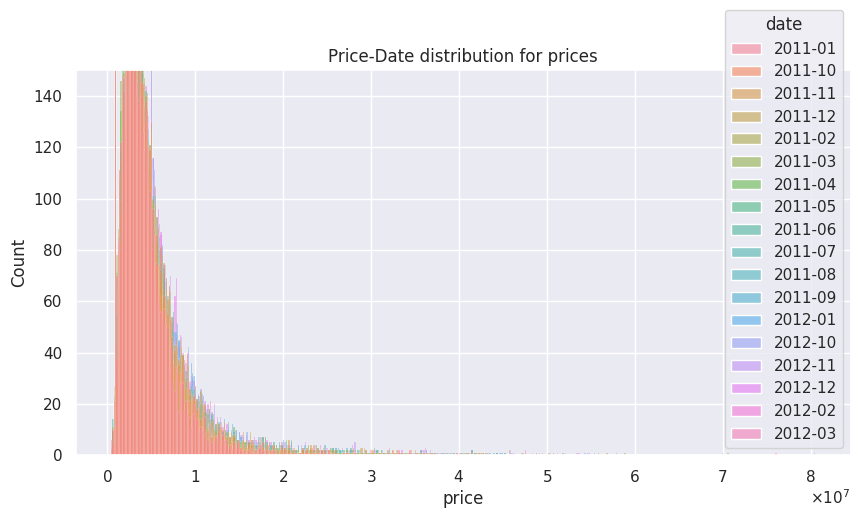

In [ ]:
plot_distribution(150, 'date')

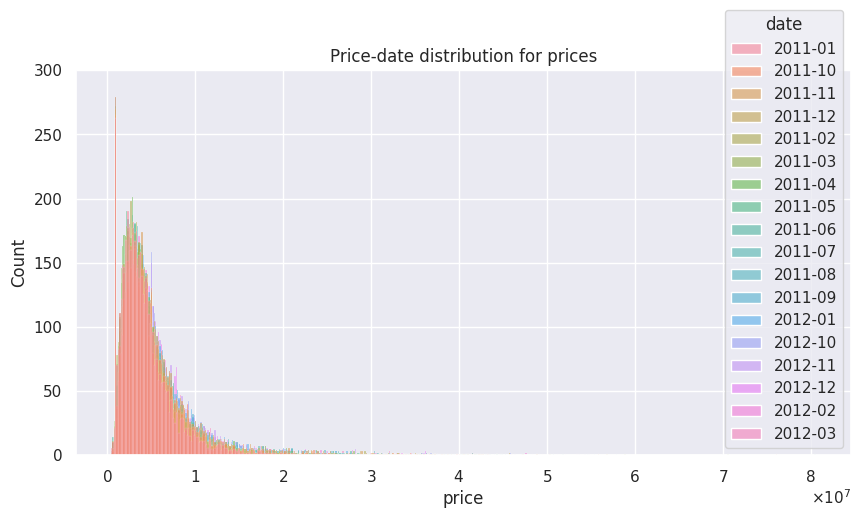

In [ ]:
plot_distribution(300, 'date')

### So, looks like to be similar distributions right there. We may notice that old and fresh flats could be both expensive and cheap. But let's try to divide the whole period and take the half.

In [ ]:
prices_dataset = pd.read_csv('train.csv')
prices_dataset = prices_dataset.drop(columns = ['id'])
prices_dataset['date'] = pd.to_datetime(prices_dataset['date'])
all_dates = prices_dataset['date']

print(f'Max date is {all_dates.max()}')
print(f'Min date is {all_dates.min()}')
print(f'Median date is {all_dates.median()}')

Max date is 2012-12-01 00:00:00
Min date is 2011-01-01 00:00:00
Median date is 2011-09-01 00:00:00


In [ ]:
before_median_date = prices_dataset[prices_dataset['date'] < all_dates.median()]
after_median_date = prices_dataset[prices_dataset['date'] >= all_dates.median()]

prices_dataset['flag_before_after'] = prices_dataset['date'] >= all_dates.median()
# prices_dataset.head()

In [ ]:
prices_dataset['flag_before_after'] = prices_dataset['flag_before_after'].astype(int)

### And Let's look for the distribution:

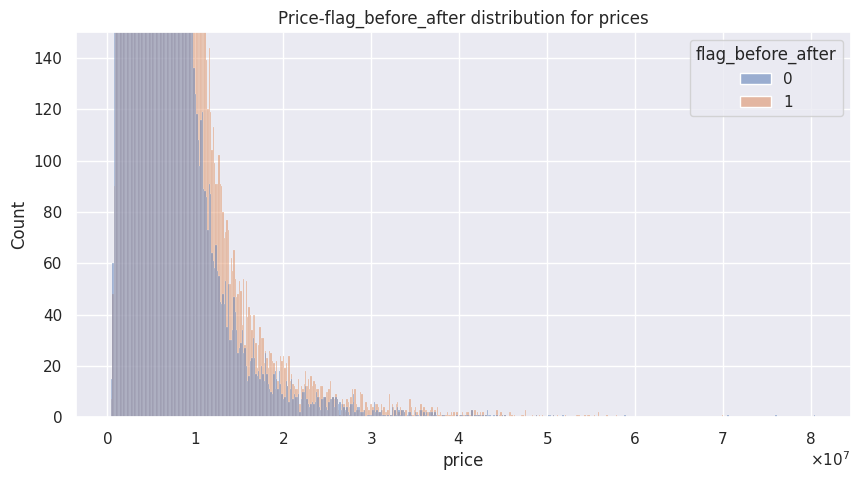

In [ ]:
plot_distribution(ylim = 150, hue = 'flag_before_after')

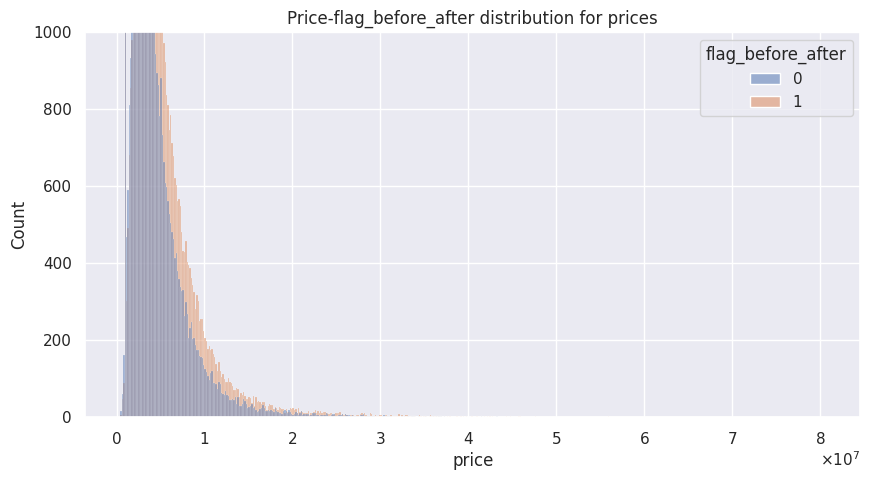

In [ ]:
plot_distribution(ylim = 1000, hue = 'flag_before_after')

### So, the difference is shown btw. I wanna try 3 periods.

In [ ]:
max_date = prices_dataset['date'].max()
min_date = prices_dataset['date'].min()

median_date = prices_dataset['date'].median()

first_midpoint = min_date + (median_date - min_date) / 2

second_midpoint = median_date + (max_date - median_date) / 2


def three_periods_divison(date, first_midpoint, second_midpoint):
  if date < first_midpoint:
    return 1
  elif first_midpoint <= date < second_midpoint:
    return 2
  else:
    return 3

prices_dataset['three_periods'] = prices_dataset['date'].apply(three_periods_divison,
                                                               args = (first_midpoint,
                                                                       second_midpoint))

print(f"Max date is: {max_date}")
print(f"Мin date is: {min_date}")
print("First mid point:")
print(first_midpoint)
print("Second mid point:")
print(second_midpoint)

Max date is: 2012-12-01 00:00:00
Мin date is: 2011-01-01 00:00:00
First mid point:
2011-05-02 12:00:00
Second mid point:
2012-04-16 12:00:00


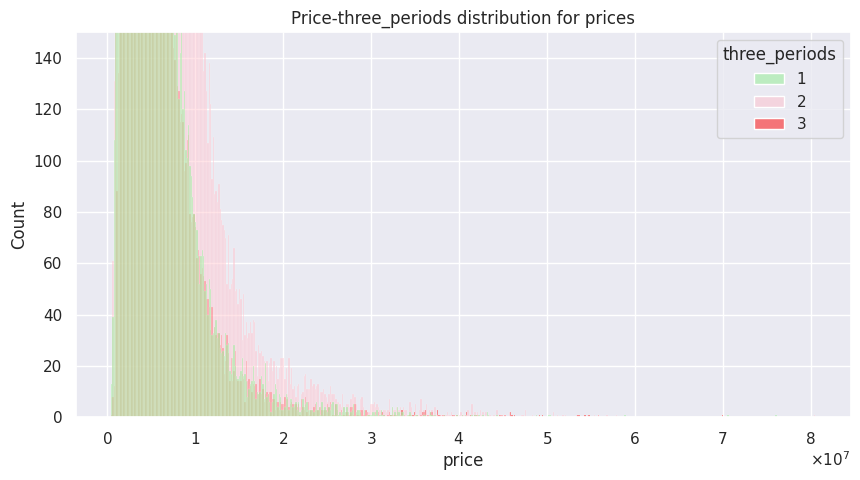

In [ ]:
plot_distribution(ylim = 150, hue = 'three_periods')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, '2011-04-01'),
  Text(1, 0, '2011-03-01'),
  Text(2, 0, '2011-12-01'),
  Text(3, 0, '2011-07-01'),
  Text(4, 0, '2011-09-01'),
  Text(5, 0, '2011-08-01'),
  Text(6, 0, '2011-01-01'),
  Text(7, 0, '2012-11-01'),
  Text(8, 0, '2011-02-01'),
  Text(9, 0, '2012-02-01'),
  Text(10, 0, '2011-11-01'),
  Text(11, 0, '2012-12-01'),
  Text(12, 0, '2011-05-01'),
  Text(13, 0, '2012-10-01'),
  Text(14, 0, '2012-01-01'),
  Text(15, 0, '2011-06-01'),
  Text(16, 0, '2012-03-01'),
  Text(17, 0, '2011-10-01')])

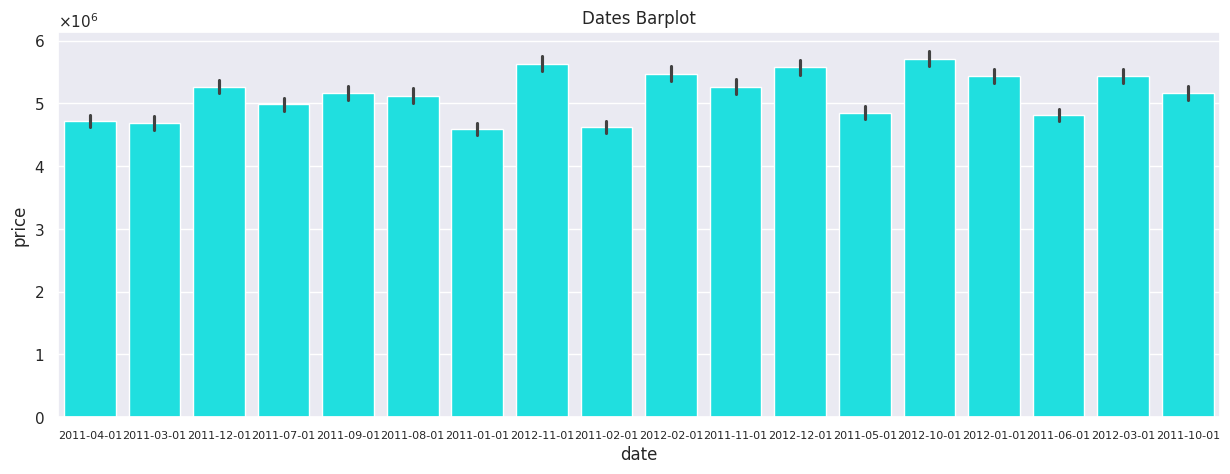

In [195]:
plt.figure(figsize = (15, 5))
plt.gca().yaxis.set_major_formatter(formatter)
sns.barplot(data = prices_dataset, x = 'date', y = 'price', color = 'cyan')
plt.title('Dates Barplot')
plt.xticks(fontsize = 8)

### So, I assume the double date division to be solid. So, probably, I'll convert date feature to True/False depending on the before/after mid_date. Or Use One-Hot or Hashing Trick. Go on!

### Let's have a view on the street_id feature:

In [56]:
street_id = prices_dataset['street_id']

In [57]:
street_id.nunique()

672

#### So, we have 672 unique street with having no idea about it's qualities and price impact. But in real life of coure street for example in the center increases the flat's price. I wanna try to test hypothesis and sort by street_id.

In [ ]:
prices_dataset = prices_dataset.sort_values(by=['street_id'], ascending = True)

In [ ]:
median_street_id = prices_dataset['street_id'].median()
median_street_id

334.0

In [ ]:
prices_dataset['street_id_flag'] = prices_dataset['street_id'] > median_street_id
prices_dataset['street_id_flag'] = prices_dataset['street_id_flag'].astype(int)

<ipython-input-97-2f84608c91d3>:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data = prices_dataset, x = 'price', hue = hue, palette = ['lightgreen', 'pink', 'red'])


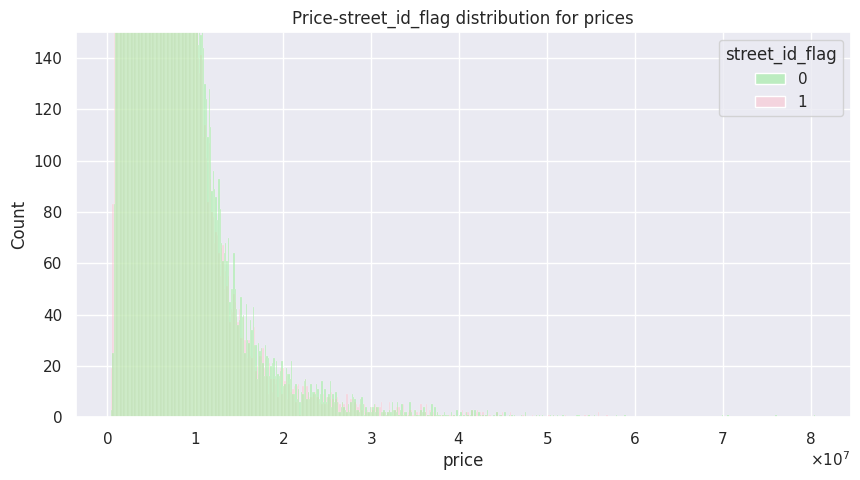

In [ ]:
plot_distribution(ylim=150, hue='street_id_flag')

### No, this is garbage research. But what if we try to calculate the mean for each street_id and make the analysis:

In [58]:
def calculate_means_stddev():
  mean_array = {}
  std_dev_array = {}
  for street_id in prices_dataset['street_id'].unique():
      prices = prices_dataset[prices_dataset['street_id'] == street_id]['price']
      mean_array.update({street_id : prices.mean()})
      std_dev_array.update({street_id : prices.std()})
      # break
  return mean_array, std_dev_array

mean_stddev = calculate_means_stddev()

In [59]:
type(mean_stddev[0])

dict

In [60]:
len(mean_stddev[0]), len(mean_stddev[1])

(672, 672)

In [ ]:
max(mean_stddev[0].values()), min(mean_stddev[0].values())

(19440871.21212121, 1253658.9147286823)

In [ ]:
type(mean_stddev[0].values())

dict_values

Text(0, 0.5, 'Price')

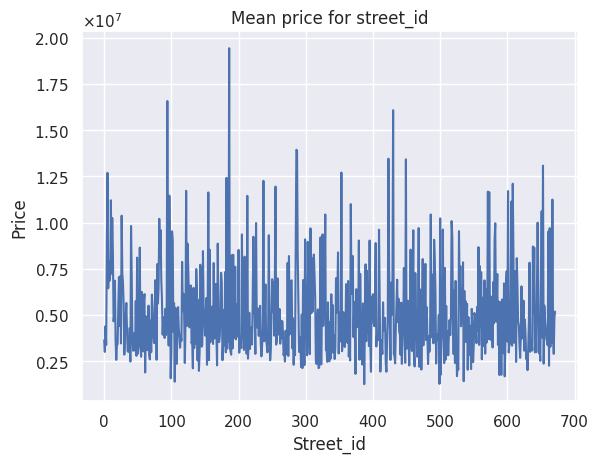

In [64]:
dict_street_id = mean_stddev[0]
ordered_dict_street_id = collections.OrderedDict(sorted(dict_street_id.items()))
sns.lineplot(x = ordered_dict_street_id.keys(), y = ordered_dict_street_id.values())
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Mean price for street_id')
plt.xlabel('Street_id')
plt.ylabel('Price')

### So, there's heterogenity right there.

### We may see that some street_id has great average flat cost than others. Distribution of means will show us this:

<ipython-input-197-9ecce464b1b5>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x = list(mean_stddev[0].values()), palette = ['lightgreen', 'pink', 'red'], kde = True)


Text(0.5, 1.0, "Mean ID cost's distribution")

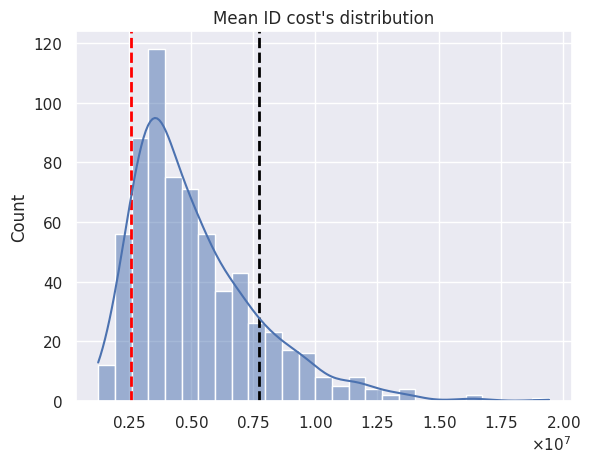

In [ ]:
plt.gca().xaxis.set_major_formatter(formatter)
plt.axvline(np.quantile(list(mean_stddev[0].values()), 0.1), color = 'red', linestyle = 'dashed',
            linewidth = 2)
plt.axvline(np.quantile(list(mean_stddev[0].values()), 0.85), color = 'black', linestyle = 'dashed',
            linewidth = 2)
sns.histplot(x = list(mean_stddev[0].values()), palette = ['lightgreen', 'pink', 'red'], kde = True)

plt.title("Mean ID cost's distribution")

(0.0, 100.0)

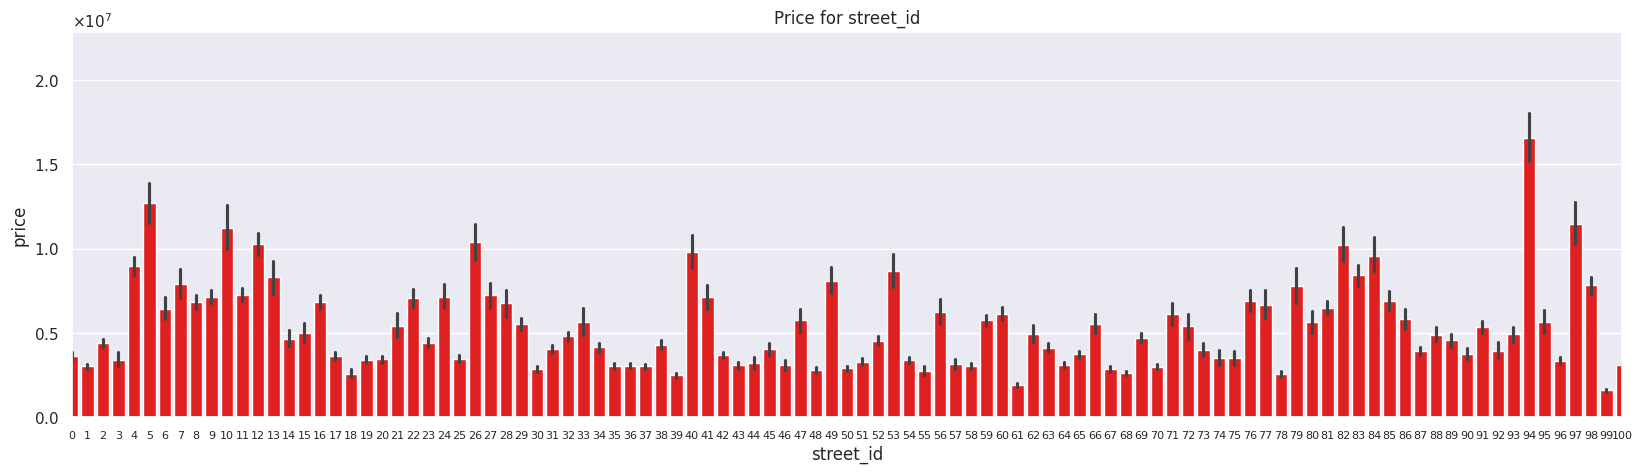

In [101]:
plt.figure(figsize = (20, 5))
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Price for street_id')
# plt.axhline(y = 0.7*10**7, color = 'blue', linestyle = '--', linewidth = 2)
sns.barplot(data = prices_dataset, x = 'street_id', y = 'price', color = 'red')
plt.xticks(fontsize = 8)
plt.xlim([0, 100])

### As we see, some street_id's are expensive and some not. But if we'll try to One-hot encode this feature we'll get extra 672 features. That's much. I'll try to divide the street on groups. Or... I'm more into Hashing Trick usage there.

### I gonna try to make 3 street_id ranges:
1. Cheap streets => less than 10% quantile.
2. Middle streets => greater than 10% but less than 76% quantile.
3. Expensive streets => greater than 76% quantile.

### Let's decode this logic:

In [ ]:
len(list(mean_stddev[0].values()))

672

In [ ]:
def create_street_groups(dict_):
  array = list(dict_.values())
  groups_street_id = {}
  for i in range(len(array)):
    if array[i] < np.quantile(array, 0.1):
      groups_street_id[list(dict_.keys())[i]] = 1
    elif np.quantile(array, 0.85) > array[i] >= np.quantile(array, 0.1):
      groups_street_id[list(dict_.keys())[i]] = 2
    else:
      groups_street_id[list(dict_.keys())[i]] = 3
  return groups_street_id

group_distribution = create_street_groups(mean_stddev[0])

In [ ]:
len(group_distribution)

672

In [ ]:
prices_dataset = prices_dataset.drop(columns = ['street_id_flag'])

In [ ]:
prices_dataset['street_group'] = prices_dataset['street_id'].map(group_distribution)

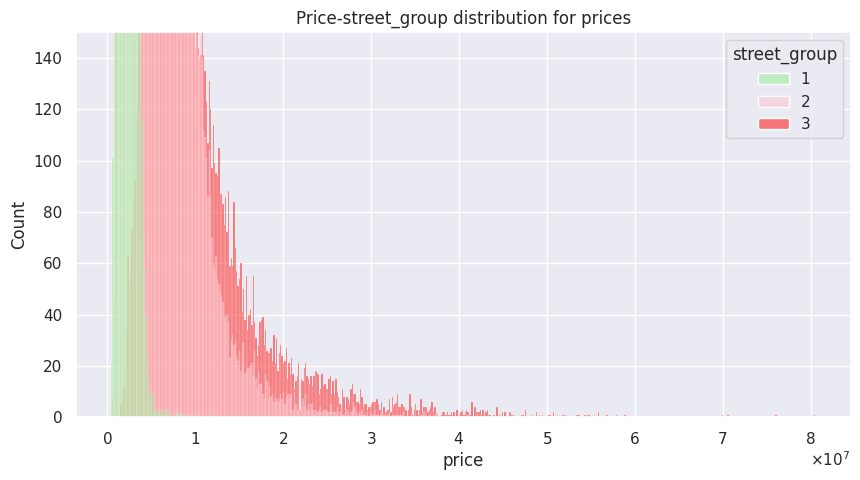

In [ ]:
plot_distribution(150, hue = 'street_group')

### Awesome: I got what I needed! Save & continue tomorrow!

In [ ]:
prices_dataset.to_csv('first_update_predict_prices.csv')

### Let's keep fit & go on! ***From this spot we will restore the test_file***

In [105]:
prices_dataset = pd.read_csv('tools\\first_update_predict_prices.csv')
prices_dataset = prices_dataset.drop(columns = ['Unnamed: 0'])

In [111]:
prices_test_dataset = pd.read_csv('tools\\test.csv')

### Here I save rooms dataset to include it in final preprocessed data:

In [112]:
rooms_test = prices_test_dataset['rooms']

In [113]:
rooms_test.shape

(100000,)

In [ ]:
for column in prices_test_dataset.columns:
    print(f"{column}: ")
    print(f"{len(prices_test_dataset[column].unique())}")
    print()

In [106]:
prices_test_dataset = prices_test_dataset.drop(columns=['id'])

In [56]:
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw8,kw9,kw10,kw11,kw12,kw13,price,flag_before_after,three_periods,street_group
0,2011-04-01,0,NaN,5,61,3,0,25.0,NaN,1,...,0,0,0,0,0,0,4294000,0,1,2
1,2011-03-01,0,0.0,3,31,1,0,30.0,1.0,2,...,0,0,0,0,0,0,1572000,0,1,2
2,2011-12-01,0,0.0,6,63,3,0,15.0,0.0,2,...,0,0,0,0,0,0,5380000,1,2,2
3,2011-07-01,0,1.0,1,61,3,1,10.0,NaN,7,...,0,0,0,0,0,0,6106000,0,2,2
4,2011-12-01,0,1.0,1,34,1,0,20.0,0.0,4,...,0,0,0,0,0,0,3805000,1,2,2


In [111]:
prices_test_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,2012-3,459,NaN,1,60,3,1,30.0,0.0,4,...,0,0,0,0,0,0,0,0,0,0
1,2012-3,344,1.0,10,52,2,1,NaN,NaN,4,...,0,0,0,0,0,0,0,0,0,0
2,2012-3,585,0.0,4,54,3,0,30.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-3,494,NaN,2,52,2,1,25.0,1.0,3,...,0,0,0,0,0,0,0,0,0,0
4,2012-3,622,1.0,9,60,3,1,15.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0


### Let's process the 'build_tech' column. There are a lot of NaN values and that's interesting how to deal with it:

In [112]:
build_tech = prices_dataset['build_tech']
build_tech_nan = prices_dataset['build_tech'][prices_dataset['build_tech'].isna() == True]
build_tech_0 = prices_dataset['build_tech'][prices_dataset['build_tech'] == 0]
build_tech_1 = prices_dataset['build_tech'][prices_dataset['build_tech'] == 1]
build_tech_2 = prices_dataset['build_tech'][prices_dataset['build_tech'] == 2]
print(f'Length of total: {len(build_tech)}')
print(f'Length of tech_0: {len(build_tech_0)}')
print(f'Length of tech_1: {len(build_tech_1)}')
print(f'Length of tech_2: {len(build_tech_2)}')
print(f'Length of NaN: {len(build_tech_nan)}')

Length of total: 100000
Length of tech_0: 35845
Length of tech_1: 31611
Length of tech_2: 2809
Length of NaN: 29735


### Around of 30 % are NaN... Let's have a look whether it impact on target feature?

In [113]:
build_tech_nan_data = prices_dataset[prices_dataset['build_tech'].isna() == True]
build_tech_nan_data_test = prices_test_dataset[prices_test_dataset['build_tech'].isna() == True]

In [114]:
len(build_tech_nan_data), len(build_tech_nan_data_test)

(29735, 30020)

<ipython-input-27-37ed7fd3ffc6>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = build_tech_nan_data, x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 0.5, kde = True)


(0.0, 1000.0)

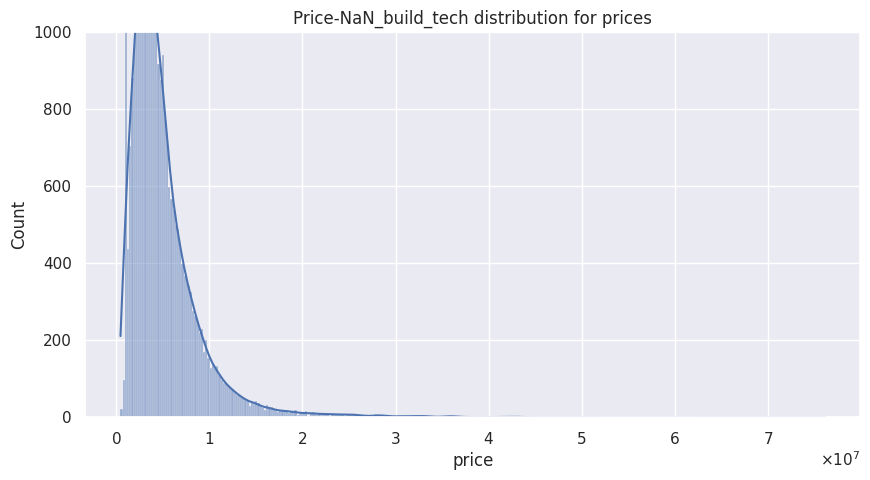

In [27]:
figure = plt.figure(figsize = (10, 5))

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = build_tech_nan_data, x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 0.5, kde = True)
plt.title(f'Price-NaN_build_tech distribution for prices')
plt.ylim([0, 1000])

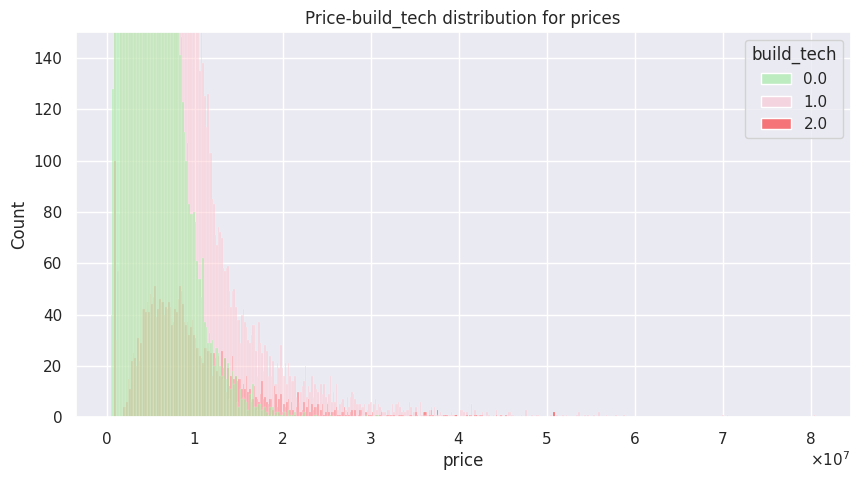

In [19]:
plot_distribution(ylim = 150, hue = 'build_tech')

### So, we actually see that NaN values could be in 3 tech-classes both but...

### But I'm going to fit another technique. Let's assume that the main features corresponding to flats build_tech are area & price. I'll try to build-up Nearest Neighbors Model based on numerical features and try to classify NaN values whether they are build_tech or not!
### Let's implement it:

In [115]:
prices_dataset_build_tech_fit = prices_dataset[['area', 'build_tech']]
prices_dataset_build_tech_fit_test = prices_test_dataset[['area', 'build_tech']]

In [116]:
prices_dataset_build_tech_fit.head()

,area,build_tech
0,61,NaN
1,31,0.0
2,63,0.0
3,61,1.0
4,34,1.0


In [118]:
prices_dataset_build_tech_fit_test.head()

,area,build_tech
0,60,NaN
1,52,1.0
2,54,0.0
3,52,NaN
4,60,1.0


In [119]:
X_train_build_tech = prices_dataset_build_tech_fit[prices_dataset_build_tech_fit['build_tech'].isna() == False]
X_implement_build_tech = prices_dataset_build_tech_fit[prices_dataset_build_tech_fit['build_tech'].isna() == True]
X_implement_build_tech_test = prices_dataset_build_tech_fit_test[prices_dataset_build_tech_fit_test['build_tech'].isna() == True]
Y_train_build_tech = X_train_build_tech['build_tech']
X_train_build_tech = X_train_build_tech.drop(columns = ['build_tech'])
X_implement_build_tech = X_implement_build_tech.drop(columns = ['build_tech'])

In [120]:
len(X_train_build_tech)

70265

In [121]:
X_train_build_tech.head()

,area
1,31
2,63
3,61
4,34
5,59


In [122]:
len(X_implement_build_tech)

29735

In [123]:
X_implement_build_tech.head()

,area
0,61
9,61
12,34
22,59
29,34


In [124]:
len(X_implement_build_tech_test)

30020

In [125]:
X_implement_build_tech_test = X_implement_build_tech_test.drop(columns = ['build_tech'])

In [126]:
X_implement_build_tech_test.head()

,area
0,60
3,52
9,35
15,61
17,32


In [127]:
Y_train_build_tech.head()

1    0.0
2    0.0
3    1.0
4    1.0
5    0.0
Name: build_tech, dtype: float64

In [128]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_build_tech, Y_train_build_tech, test_size = 0.2,
                                                    random_state = 42)

### Ok, let's have a try!

In [69]:
knn_build_tech = KNeighborsClassifier(n_neighbors=11)
knn_build_tech.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=11)

In [70]:
print(classification_report(y_true = Y_test, y_pred = knn_build_tech.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.68      0.67      0.67      7216
         1.0       0.59      0.65      0.62      6265
         2.0       0.29      0.02      0.03       572

    accuracy                           0.63     14053
   macro avg       0.52      0.44      0.44     14053
weighted avg       0.62      0.63      0.62     14053



In [66]:
Y_train_build_tech.unique()

array([0., 1., 2.])

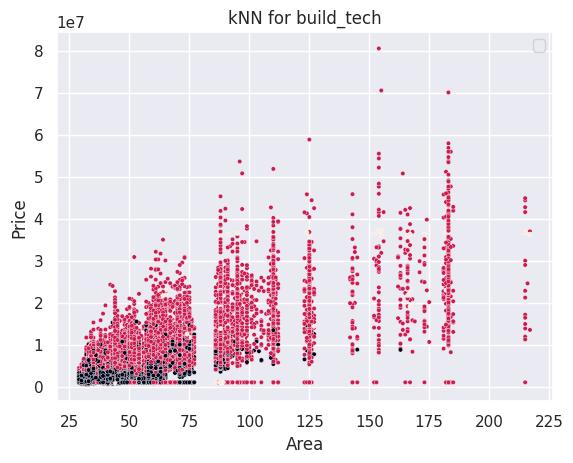

In [71]:
y_pred_build_tech = knn_build_tech.predict(X_train_build_tech)
plt.figure()
sns.scatterplot(x = X_train_build_tech.iloc[:, 0],
                y = X_train_build_tech.iloc[:, 1],  c = y_pred_build_tech, s=10)
plt.title('kNN for build_tech')
plt.xlabel('Area')
plt.ylabel('Price')
plt.legend()
plt.show()

### May be with RandomForest...

In [129]:
rf_build_tech = RandomForestClassifier(max_depth = 25)
rf_build_tech.fit(X_train, Y_train)

RandomForestClassifier(max_depth=25)

In [130]:
print(classification_report(y_true = Y_test, y_pred = rf_build_tech.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82      7216
         1.0       0.77      0.79      0.78      6265
         2.0       0.74      0.56      0.63       572

    accuracy                           0.80     14053
   macro avg       0.78      0.72      0.75     14053
weighted avg       0.80      0.80      0.80     14053



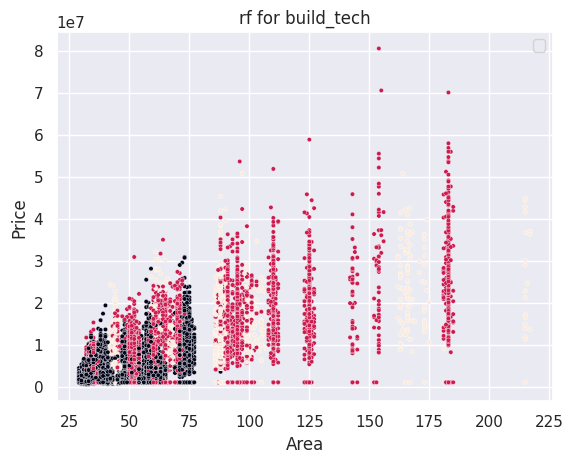

In [15]:
y_pred_build_tech = rf_build_tech.predict(X_train_build_tech)
plt.figure()
sns.scatterplot(x = X_train_build_tech.iloc[:, 0],
                y = X_train_build_tech.iloc[:, 1],  c = y_pred_build_tech, s=10)
plt.title('rf for build_tech')
plt.xlabel('Area')
plt.ylabel('Price')
plt.legend()
plt.show()

### So, actually there are some division between build_tech classes depending on area and price both. So, I'll use RF to replace NaN values as:

In [131]:
predicted_for_NaN = rf_build_tech.predict(X_implement_build_tech)
predicted_for_NaN_test = rf_build_tech.predict(X_implement_build_tech_test)

In [132]:
predicted_for_NaN_test.shape

(30020,)

In [133]:
print(len(predicted_for_NaN))

29735


In [134]:
X_implement_build_tech['predicted_build_tech'] = predicted_for_NaN
X_implement_build_tech.head()
X_implement_build_tech_test['predicted_build_tech'] = predicted_for_NaN_test
print(len(X_implement_build_tech), len(X_implement_build_tech_test))

29735 30020


In [135]:
X_implement_build_tech['predicted_build_tech'].head()

0     1.0
9     1.0
12    0.0
22    0.0
29    0.0
Name: predicted_build_tech, dtype: float64

In [136]:
X_implement_build_tech_test['predicted_build_tech'].unique()

array([1., 0., 2.])

### Ok, rather strange heuristic (от лукавого), but let's replace NaNs:

In [70]:
prices_dataset['build_tech'] = prices_dataset['build_tech'].fillna(X_implement_build_tech['predicted_build_tech'])
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw8,kw9,kw10,kw11,kw12,kw13,price,flag_before_after,three_periods,street_group
0,2011-04-01,0,1.0,5,61,3,0,25.0,NaN,1,...,0,0,0,0,0,0,4294000,0,1,2
1,2011-03-01,0,0.0,3,31,1,0,30.0,1.0,2,...,0,0,0,0,0,0,1572000,0,1,2
2,2011-12-01,0,0.0,6,63,3,0,15.0,0.0,2,...,0,0,0,0,0,0,5380000,1,2,2
3,2011-07-01,0,1.0,1,61,3,1,10.0,NaN,7,...,0,0,0,0,0,0,6106000,0,2,2
4,2011-12-01,0,1.0,1,34,1,0,20.0,0.0,4,...,0,0,0,0,0,0,3805000,1,2,2


In [137]:
prices_test_dataset['build_tech'] = prices_test_dataset['build_tech'].fillna(X_implement_build_tech_test['predicted_build_tech'])

In [138]:
len(prices_test_dataset[prices_test_dataset['build_tech'].isna() == True])

0

In [71]:
prices_test_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,2012-3,459,1.0,1,60,3,1,30.0,0.0,4,...,0,0,0,0,0,0,0,0,0,0
1,2012-3,344,1.0,10,52,2,1,NaN,NaN,4,...,0,0,0,0,0,0,0,0,0,0
2,2012-3,585,0.0,4,54,3,0,30.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-3,494,1.0,2,52,2,1,25.0,1.0,3,...,0,0,0,0,0,0,0,0,0,0
4,2012-3,622,1.0,9,60,3,1,15.0,NaN,1,...,0,0,0,0,0,0,0,0,0,0


### Ok, we did that. Let's dive into another feature: ***Floor***

In [75]:
floor = prices_dataset['floor']
print(f"Unique values for floor: {' '.join([str(floor) for floor in floor.unique()])}")
print(f'Number of Unique values: {len(floor.unique())}')

Unique values for floor: 5 3 6 1 12 2 9 4 7 11 10 8 23 21 18 20 14 25 13 22 19 16 15 17 24
Number of Unique values: 25


In [76]:
floor[floor.isna() == True]

Series([], Name: floor, dtype: int64)

### So, according to the РБК post, difference in price for down and up floors could be in order of 37%. Of course, depends on class and other features, but let's have a look how's this fact presented in our data:

### For example, let's take flats with floor <=4, floor in (4, 10] and >10 and count mean_value:

In [77]:
flats_down = prices_dataset[prices_dataset['floor'] <= 3]
flats_up = prices_dataset[prices_dataset['floor'] > 10]
flats_middle = prices_dataset[(prices_dataset['floor'] <= 10) & (prices_dataset['floor'] > 3)]

print(f'Number down flats: {len(flats_down)}')
print(f'Number middle flats: {len(flats_middle)}')
print(f'Number up flats: {len(flats_up)}')

Number down flats: 39003
Number middle flats: 50941
Number up flats: 10056


In [78]:
flats_up['price'].head()

6      1000000
21     4259000
30     6058000
139    3366000
158    1870000
Name: price, dtype: int64

In [79]:
print(f'Mean price for down flats: {flats_down["price"].mean()}')
print(f'Mean price for up flats: {flats_up["price"].mean()}')
print(f'Mean price for middle flats: {flats_middle["price"].mean()}')

Mean price for down flats: 4533920.493295387
Mean price for up flats: 7060338.703261734
Mean price for middle flats: 5221812.037455095


### So, the higher -> the more expensive in average.

In [80]:
print(f'Std for down flats: {flats_down["price"].std()}')
print(f'Std for up flats: {flats_up["price"].std()}')
print(f'Std for middle flats: {flats_middle["price"].std()}')

Std for down flats: 3458401.282360918
Std for up flats: 5282688.300420626
Std for middle flats: 4329011.476962485


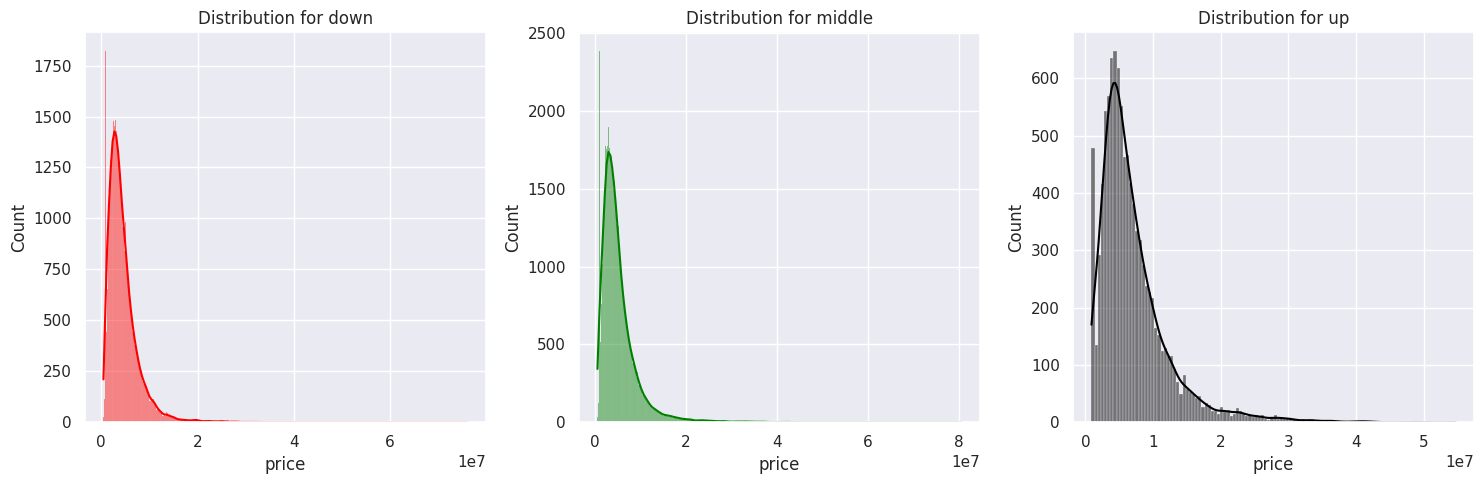

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(flats_down['price'], ax=axes[0], kde=True, color = 'red')
sns.histplot(flats_middle['price'], ax=axes[1], kde=True, color = 'green')
sns.histplot(flats_up['price'], ax=axes[2], kde=True, color = 'black')

axes[0].set_title('Distribution for down')
axes[1].set_title('Distribution for middle')
axes[2].set_title('Distribution for up')

plt.tight_layout()
plt.show()

(0.0, 1800.0)

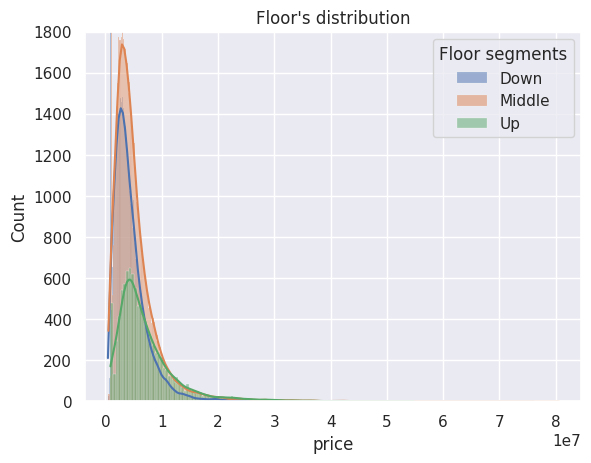

In [84]:
sns.histplot(flats_down['price'], kde=True, label = 'Down')
sns.histplot(flats_middle['price'], kde=True, label = 'Middle')
sns.histplot(flats_up['price'], kde=True, label = 'Up')

plt.legend(title = 'Floor segments')
plt.title("Floor's distribution")
plt.ylim([0, 1800])

(0.0, 800.0)

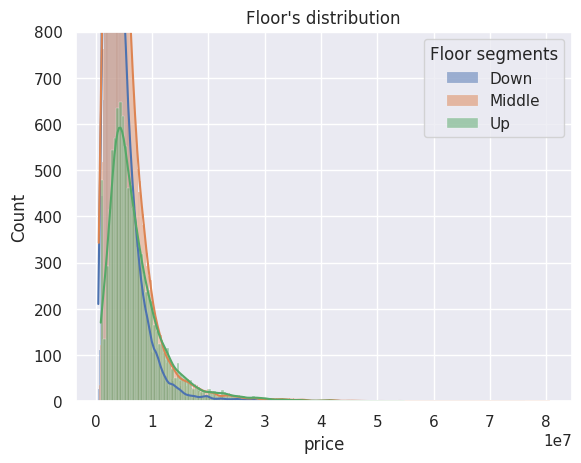

In [85]:
sns.histplot(flats_down['price'], kde=True, label = 'Down')
sns.histplot(flats_middle['price'], kde=True, label = 'Middle')
sns.histplot(flats_up['price'], kde=True, label = 'Up')

plt.legend(title = 'Floor segments')
plt.title("Floor's distribution")
plt.ylim([0, 800])

### Let's denote how's the prices for min & max floor differ:

In [28]:
min_floor = floor.unique().min()
max_floor = floor.unique().max()

flats_min = prices_dataset[prices_dataset['floor'] == min_floor]
flats_max = prices_dataset[prices_dataset['floor'] == max_floor]

print(f'Number of min_floor flats: {len(flats_min)}')
print(f'Mean of max_floor flats: {len(flats_max)}')

print(f'Mean price for min_floor flats: {flats_min["price"].mean()}')
print(f'Mean price for max_floor flats: {flats_max["price"].mean()}')

Number of min_floor flats: 12951
Mean of max_floor flats: 207
Mean price for min_floor flats: 4263849.200833912
Mean price for max_floor flats: 7839391.304347826


In [40]:
floors_sorted = sorted(np.asarray(floor.unique()))

In [46]:
means_array = []
for floor in floors_sorted:
  flats_floor = prices_dataset[prices_dataset['floor'] == floor]
  flats_floor_mean = flats_floor["price"].mean()
  means_array.append(flats_floor_mean)

Text(0, 0.5, 'Price')

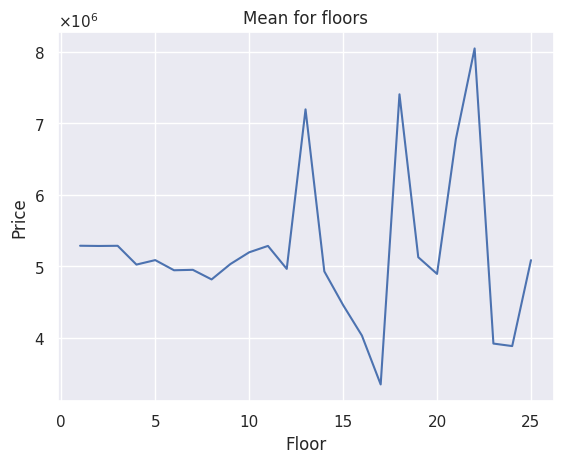

In [88]:
sns.lineplot(x = floors_sorted, y = means_array)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Mean for floors')
plt.xlabel('Floor')
plt.ylabel('Price')

<Axes: title={'center': 'Price for floors'}, xlabel='floor', ylabel='price'>

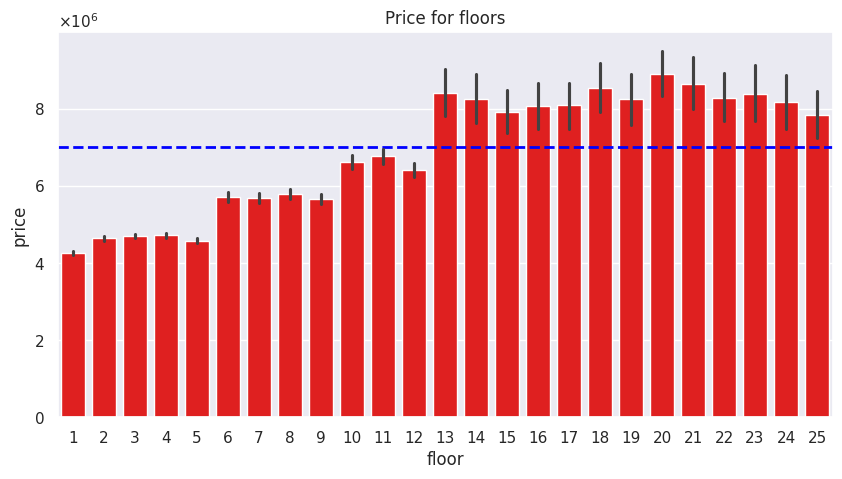

In [94]:
plt.figure(figsize = (10, 5))
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Price for floors')
plt.axhline(y = 0.7*10**7, color = 'blue', linestyle = '--', linewidth = 2)
sns.barplot(data = prices_dataset, x = 'floor', y = 'price', color = 'red')

### In general(3 floor ranges: down, middle & up) it's not so significant imho. Also on the total trend there's something like impurity. But barplot shows that down floors are cheaper than up. So, probably I'll apply the Hashing Trick technique for this feature and will work with it as it's cathegorical.

### So, have a break & continue!

In [87]:
prices_dataset.to_csv('second_update_predict_prices.csv')

In [110]:
prices_dataset = pd.read_csv('second_update_predict_prices.csv')
prices_dataset = prices_dataset.drop(columns = ['Unnamed: 0'])

### Continue with area:

In [111]:
prices_area = prices_dataset['area']

print(f'Number of NaN values: {len(prices_area[prices_area.isna() == True])}')

Number of NaN values: 0


### What about distribution?

Text(0.5, 1.0, 'Area Distribution')

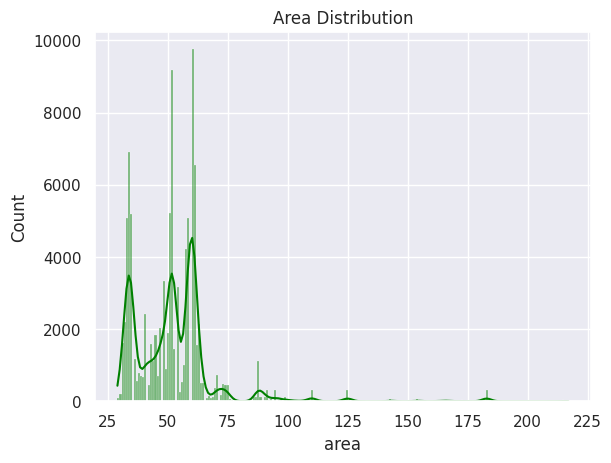

In [112]:
sns.histplot(x = prices_dataset['area'], color = 'green', kde = True)
plt.title('Area Distribution')

(0.0, 3000.0)

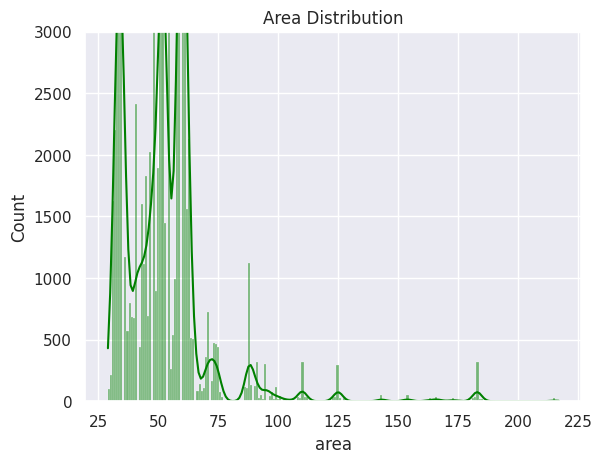

In [115]:
sns.histplot(x = prices_dataset['area'], color = 'green', kde = True)
plt.title('Area Distribution')
plt.ylim([0, 3000])

### Let's calculate some correlations:

In [117]:
area_price_corr = prices_dataset['area'].corr(prices_dataset['price'])
print(f"Correlation between area & price: {area_price_corr}")

Correlation between area & price: 0.6626614061799292


In [119]:
area_dist_corr = prices_dataset['area'].corr(prices_dataset['metro_dist'])
print(f"Correlation between area & metro_dist: {area_dist_corr}")

Correlation between area & metro_dist: 0.005430918834783408


In [120]:
area_rooms_corr = prices_dataset['area'].corr(prices_dataset['rooms'])
print(f"Correlation between area & rooms number: {area_rooms_corr}")

Correlation between area & rooms number: 0.7918293451334185


### So, I guess that's significant correlation (as it was expected: the more $m^{2}$ the more expensive the flat). Also we may notice strong correlation between the rooms number and area (likewise expected). Further we should deal with it.

### Ok, go on. ***Rooms*** :

In [128]:
rooms_unique = np.asarray(prices_dataset['rooms'].unique())

print(f"Unique number of rooms: {' '.join([str(room) for room in rooms_unique])}")
print(f"Number of NaN values: { len(prices_dataset[prices_dataset['rooms'].isna() == True]) }")

Unique number of rooms: 3 1 2 4 5 6
Number of NaN values: 0


Text(0.5, 1.0, 'Rooms-price Barplot')

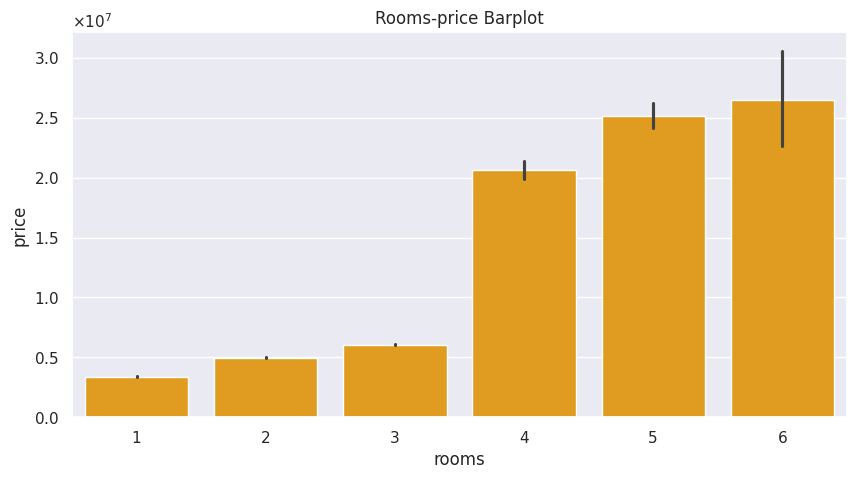

In [129]:
plt.figure(figsize = (10, 5))
plt.gca().yaxis.set_major_formatter(formatter)
sns.barplot(data = prices_dataset, x = 'rooms', y = 'price', color = 'orange')
plt.title('Rooms-price Barplot')

### Of course, that's expected. The more rooms the greater the cost.

In [132]:
for i in range(1, 7):
  print(np.exp(i))

2.718281828459045
7.38905609893065
20.085536923187668
54.598150033144236
148.4131591025766
403.4287934927351


In [133]:
for i in range(1, 7):
  print(np.log(i))

0.0
0.6931471805599453
1.0986122886681098
1.3862943611198906
1.6094379124341003
1.791759469228055


### Probably it's useful to make $exp(rooms\_number)$ to show the real difference between number of rooms (or $\ln (rooms\_number)$).
### ¡It's **NOT** cathegorical feature at all!

### Let's go for a ***balcon*** :

In [134]:
balconies_unique = np.asarray(prices_dataset['balcon'].unique())

print(f"Unique number of balconies: {' '.join([str(balcon) for balcon in balconies_unique])}")
print(f"Number of NaN values: { len(prices_dataset[prices_dataset['balcon'].isna() == True]) }")

Unique number of balconies: 0 1 2
Number of NaN values: 0


Text(0.5, 1.0, 'Balconies-price Barplot')

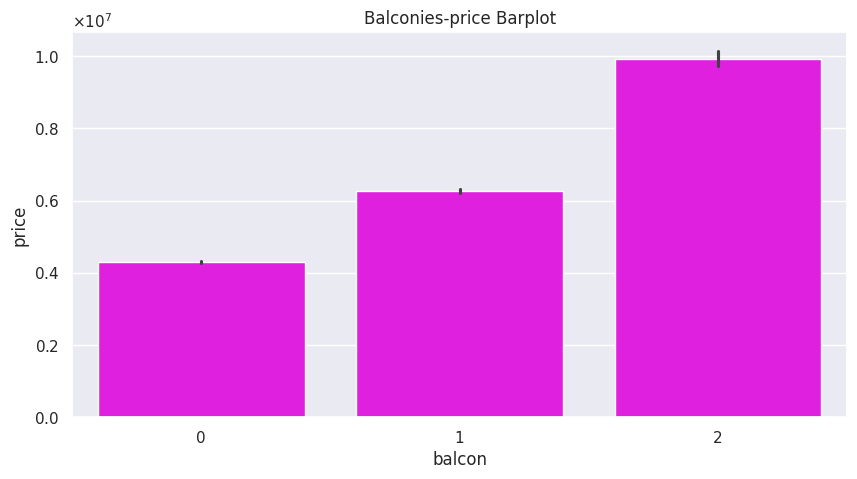

In [140]:
plt.figure(figsize = (10, 5))
plt.gca().yaxis.set_major_formatter(formatter)
sns.barplot(data = prices_dataset, x = 'balcon', y = 'price', color = 'magenta')
plt.title('Balconies-price Barplot')

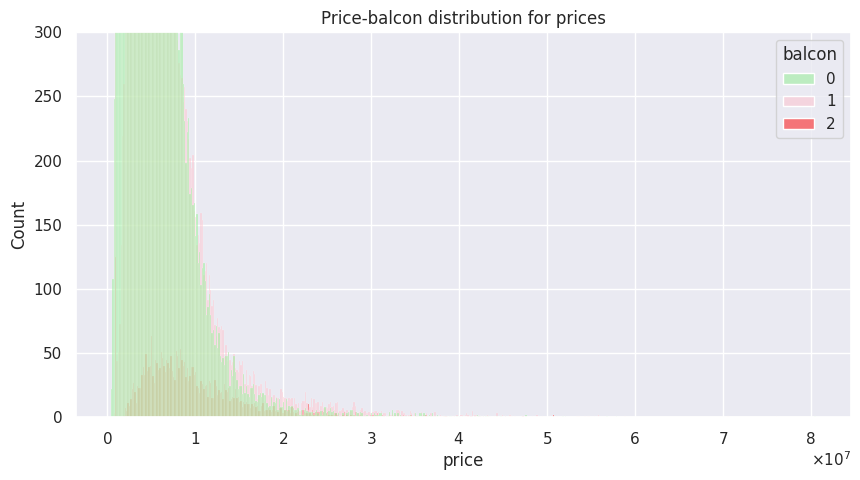

In [142]:
plot_distribution(ylim = 300, hue = 'balcon')

### Some correlations:

In [143]:
area_balcon_corr = prices_dataset['area'].corr(prices_dataset['balcon'])
print(f"Correlation between area & balconies number: {area_balcon_corr}")

Correlation between area & balconies number: 0.25676900679093057


In [144]:
price_balcon_corr = prices_dataset['price'].corr(prices_dataset['balcon'])
print(f"Correlation between price & balconies number: {price_balcon_corr}")

Correlation between price & balconies number: 0.29224166525504947


>Study note: There's impact on target.

In [145]:
rooms_balcon_corr = prices_dataset['rooms'].corr(prices_dataset['balcon'])
print(f"Correlation between rooms & balconies number: {rooms_balcon_corr}")

Correlation between rooms & balconies number: 0.10074615510215011


### So, I guess it's not cathegorical feature at all. Probably, I'll use $\ln()$ or $\exp()$ transform.

### Continue with ***metro_dist*** :

In [40]:
prices_metro_dist = prices_dataset['metro_dist']
prices_metro_dist.head()

0    25.0
1    30.0
2    15.0
3    10.0
4    20.0
Name: metro_dist, dtype: float64

In [41]:
print(f"Number of NaN values: { len(prices_dataset[prices_dataset['metro_dist'].isna() == True]) }")

Number of NaN values: 4896


### Ok, we have 4896 NaN metro_distances. We should deal with it.

### Let's have a look how's metro_distance impacts on price:

In [42]:
non_nan_metro_dist = prices_dataset[prices_dataset['metro_dist'].isna() == False]
# non_nan_metro_dist.head()
print(f'Number of non-NaN examples: {len(non_nan_metro_dist)}')
dist_price_corr = non_nan_metro_dist['metro_dist'].corr(non_nan_metro_dist['price'])
print(f'Correlation between metro_dist and price: {dist_price_corr}')

Number of non-NaN examples: 95104
Correlation between metro_dist and price: -0.09226999778115141


<AxesSubplot: xlabel='metro_dist', ylabel='Count'>

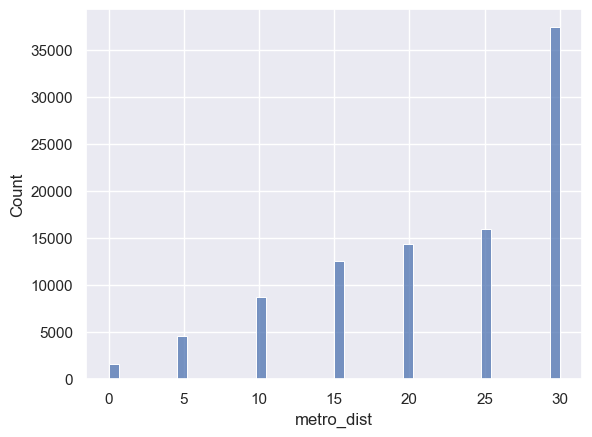

In [43]:
sns.histplot(x = non_nan_metro_dist['metro_dist'])

### So, the correlation is low. And, actually not so a lot unique values. That's why I guess, we may replace it by mean value.

In [139]:
prices_dataset['metro_dist'] = prices_dataset['metro_dist'].fillna(prices_dataset['metro_dist'].mean())
non_nan_metro_dist_update = prices_dataset[prices_dataset['metro_dist'].isna() == False]
print(f'Number of non-NaN examples *update*: {len(non_nan_metro_dist_update)}')

Number of non-NaN examples *update*: 100000


In [141]:
prices_test_dataset['metro_dist'] = prices_test_dataset['metro_dist'].fillna(prices_dataset['metro_dist'].mean())
non_nan_metro_dist_update_test = prices_test_dataset[prices_test_dataset['metro_dist'].isna() == False]
print(f'Number of non-NaN examples *update* test: {len(non_nan_metro_dist_update_test)}')

Number of non-NaN examples *update* test: 100000


In [142]:
prices_test_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,2012-3,459,1.0,1,60,3,1,30.000000,0.0,4,...,0,0,0,0,0,0,0,0,0,0
1,2012-3,344,1.0,10,52,2,1,22.081353,NaN,4,...,0,0,0,0,0,0,0,0,0,0
2,2012-3,585,0.0,4,54,3,0,30.000000,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-3,494,1.0,2,52,2,1,25.000000,1.0,3,...,0,0,0,0,0,0,0,0,0,0
4,2012-3,622,1.0,9,60,3,1,15.000000,NaN,1,...,0,0,0,0,0,0,0,0,0,0


### Some break & continue.

### Go with ***lift*** :

In [45]:
lifts = prices_dataset['g_lift'].unique()
lifts_nan = prices_dataset[prices_dataset['g_lift'].isna() == True]
lifts_not_nan = prices_dataset[prices_dataset['g_lift'].isna() == False]

print(f'Unique values are: {" ".join([str(lift) for lift in lifts])}')
print(f'Number of NaN lift valus: {len(lifts_nan)}')

Unique values are: nan 1.0 0.0
Number of NaN lift valus: 29992


### So, around the 30% of values are NaN.

<ipython-input-174-7186f3925ff3>:8: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data = prices_dataset, x = 'price', hue = 'g_lift', palette = ['lightgreen', 'pink', 'red'], alpha = 1)


(0.0, 150.0)

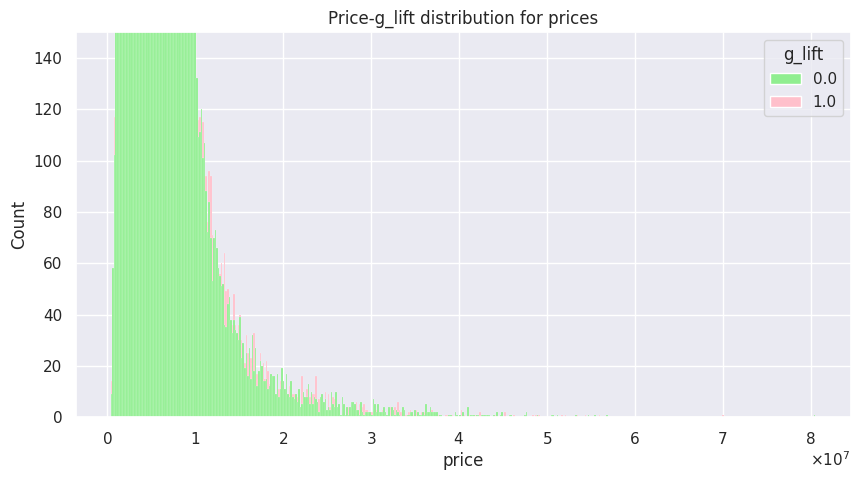

In [174]:
figure = plt.figure(figsize = (10, 5))

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
plt.gca().xaxis.set_major_formatter(formatter)

sns.histplot(data = prices_dataset, x = 'price', hue = 'g_lift', palette = ['lightgreen', 'pink', 'red'], alpha = 1)
plt.title(f'Price-g_lift distribution for prices')
plt.ylim([0, 150])

<ipython-input-179-92d7d2cc0e65>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = lifts_nan,x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 1)


<Axes: xlabel='price', ylabel='Count'>

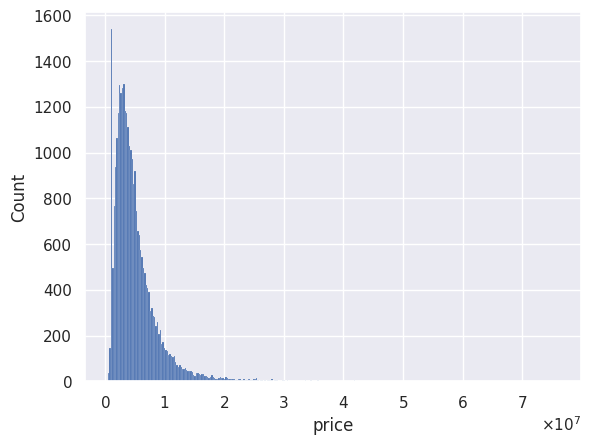

In [179]:
plt.gca().xaxis.set_major_formatter(formatter)
sns.histplot(data = lifts_nan,x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 1)

<ipython-input-177-92d7378fa99d>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = lifts_not_nan.query('g_lift == 0'),x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 1)


<Axes: xlabel='price', ylabel='Count'>

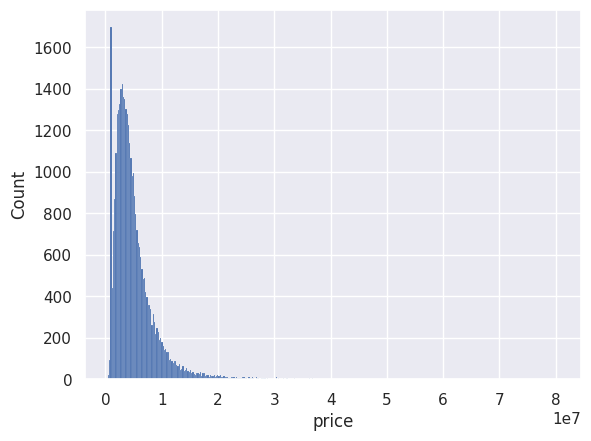

In [177]:
sns.histplot(data = lifts_not_nan.query('g_lift == 0'),x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 1)

<ipython-input-180-7580f5ac9824>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data = lifts_not_nan.query('g_lift == 1'),x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 1)


<Axes: xlabel='price', ylabel='Count'>

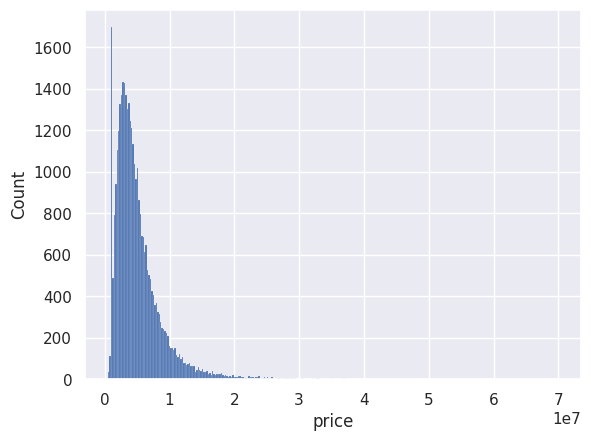

In [180]:
sns.histplot(data = lifts_not_nan.query('g_lift == 1'),x = 'price', palette = ['lightgreen', 'pink', 'red'], alpha = 1)

In [182]:
print(np.array_equal(lifts_not_nan.query('g_lift == 0')['price'], lifts_not_nan.query('g_lift == 1')['price']))
print(len(lifts_not_nan.query('g_lift == 0')['price']))
print(len(lifts_not_nan.query('g_lift == 1')['price']))

False
34935
35073


In [185]:
prices_dataset['g_lift'] = prices_dataset['g_lift'].fillna('none')

Text(0.5, 1.0, 'Lift/Not price barplot')

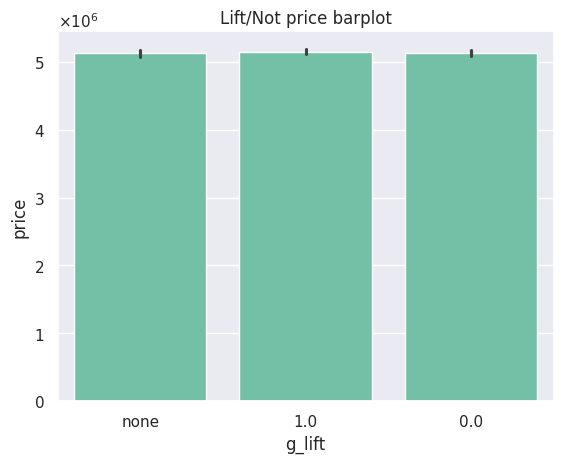

In [187]:
plt.gca().yaxis.set_major_formatter(formatter)
sns.barplot(data = prices_dataset, x = 'g_lift', y = 'price', color = 'mediumaquamarine')
plt.title('Lift/Not price barplot')

### It looks like identical btw. Probably it doesn't actually impacts on the price. That's why we may drop this column:

In [143]:
prices_dataset = prices_dataset.drop(columns = ['g_lift'])

In [144]:
prices_test_dataset = prices_test_dataset.drop(columns = ['g_lift'])

In [145]:
prices_test_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,2012-3,459,1.0,1,60,3,1,30.000000,4,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-3,344,1.0,10,52,2,1,22.081353,4,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-3,585,0.0,4,54,3,0,30.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-3,494,1.0,2,52,2,1,25.000000,3,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-3,622,1.0,9,60,3,1,15.000000,1,1,...,0,0,0,0,0,0,0,0,0,0


### Final features ahead. ***n_photos*** :

In [198]:
n_photos = prices_dataset['n_photos'].unique()
n_photos_nan = prices_dataset[prices_dataset['n_photos'].isna() == True]

print(f"Unique n_photos: {len(n_photos)}")
print(f"Number of NaN values: {len(n_photos_nan)}")

Unique n_photos: 12
Number of NaN values: 0


In [199]:
corr_price_n_photos = prices_dataset['n_photos'].corr(prices_dataset['price'])
print(f"Correlation between n_photos and price: {corr_price_n_photos}")

Correlation between n_photos and price: 0.18927677727998762


Text(0.5, 1.0, 'n_photos-price barplot')

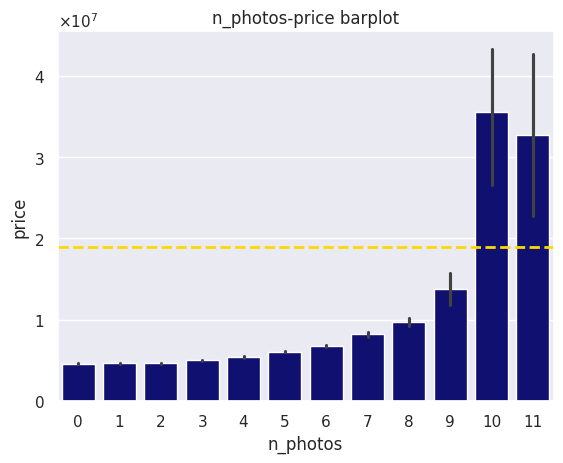

In [205]:
plt.gca().yaxis.set_major_formatter(formatter)
sns.barplot(data = prices_dataset, x = 'n_photos', y = 'price', color = 'navy')
plt.axhline(1.9*10**7, linestyle = '--', linewidth = 2, color = 'gold')
plt.title('n_photos-price barplot')

### So, there's some correlation and some difference in average prices like on the border around 9-10 photos. But there's only 116 cases:

In [210]:
len(prices_dataset[prices_dataset['n_photos'] >= 9])

116

### Ok, right now won't drop, but obviously transfrom in future (or drop).

### Finally we may transfer to the kw_{insert No.}. What's that? Let's have a look!

In [221]:
columns = ['kw' + str(i) for i in range(1, 14)]
array_mean_kw = []
for i, column in enumerate(columns):
  print(f'{column}:')
  print(f"{column} NaN count: {len(prices_dataset[prices_dataset[column].isna() == True])}")
  print(f"{column} Unique count: {len(prices_dataset[column].unique())}")
  print()
  array_mean_kw.append(prices_dataset[prices_dataset[column] == 1]['price'].mean())

kw1:
kw1 NaN count: 0
kw1 Unique count: 2

kw2:
kw2 NaN count: 0
kw2 Unique count: 2

kw3:
kw3 NaN count: 0
kw3 Unique count: 2

kw4:
kw4 NaN count: 0
kw4 Unique count: 2

kw5:
kw5 NaN count: 0
kw5 Unique count: 2

kw6:
kw6 NaN count: 0
kw6 Unique count: 2

kw7:
kw7 NaN count: 0
kw7 Unique count: 2

kw8:
kw8 NaN count: 0
kw8 Unique count: 2

kw9:
kw9 NaN count: 0
kw9 Unique count: 2

kw10:
kw10 NaN count: 0
kw10 Unique count: 2

kw11:
kw11 NaN count: 0
kw11 Unique count: 2

kw12:
kw12 NaN count: 0
kw12 Unique count: 2

kw13:
kw13 NaN count: 0
kw13 Unique count: 2



Text(0, 0.5, 'price')

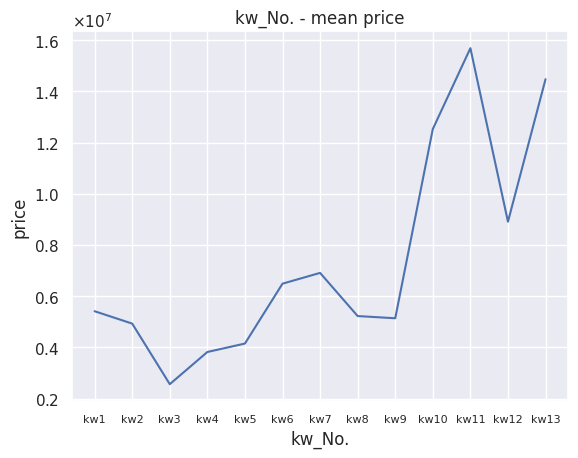

In [226]:
plt.gca().yaxis.set_major_formatter(formatter)
sns.lineplot(x = columns, y = array_mean_kw)
plt.title('kw_No. - mean price')
plt.xticks(fontsize = 8)
plt.xlabel('kw_No.')
plt.ylabel('price')

In [233]:
len(prices_dataset.iloc[:, 9:22][(prices_dataset.iloc[:, 9:22] == 0).all(axis = 1)])

33460

### Kw No. Makes difference actually. But actually I have no idea what to do with all zero kws. I guess, shold save it.

### So, all features are processed. We may save on this spot and continue later!

In [ ]:
prices_dataset.to_csv('third_update_predict_prices.csv')

In [45]:
prices_dataset = pd.read_csv('C:\\Users\\Пользователь\\Desktop\\Technopark Spring 2024\\ML\\tool_excels_predict_prices\\third_update_predict_prices.csv')
prices_dataset = prices_dataset.drop(columns = ['Unnamed: 0'])

In [158]:
prices_dataset_columns = prices_dataset.columns
string_columns = ', '.join(list(prices_dataset_columns[:len(prices_dataset_columns)-3]))

In [159]:
string_columns

'date, street_id, build_tech, floor, area, rooms, balcon, metro_dist, n_photos, kw1, kw2, kw3, kw4, kw5, kw6, kw7, kw8, kw9, kw10, kw11, kw12, kw13, price'

In [160]:
string_columns_test = ', '.join(list(prices_test_dataset.columns[:len(prices_test_dataset.columns)]))

In [161]:
string_columns_test

'date, street_id, build_tech, floor, area, rooms, balcon, metro_dist, n_photos, kw1, kw2, kw3, kw4, kw5, kw6, kw7, kw8, kw9, kw10, kw11, kw12, kw13'

### Let's sum up all features research:
* ***Date*** :<br> <br>
The fresher the flat - the greater the cost. Also division on 3 periods revealed the differences in distribution. <br>
***Review***: Stay cathegorical or use Hashing Trick or One-Hot Encoding. Or ues KMEans to find the clusters. <br><br>
* ***Street_id***:  <br><br>
There's heterogenity in mean prices for street_id_s. Some streets (or groups of streets) are cheap, but some are expensive. But One_Hot Encoding will probably get 672 extra columns what's not the best resolution. <br>
***Review***: Apply OHE or Use Hashing Trick technique. Or maybe build the clusters of Streets based on Mean Price using KMeans.<br><br>

* ***Build-tech***: <br><br>
This feature had lots of NaN values. NaNs were replaced using the RandomForestClassifier predict for residual features. This feature is cathegorical and we should apply OHE due to 3 unique values.
<br>
***Review***: Apply OHE. <br><br>

* ***Floor***: <br><br>
We had 25 total floors. The analysis showed that floors start from 10-11 are more expensive in average than down floors. I guess that using OHE is not so good, but probably Hashing Trick will give us appropriate result.<br>
***Review***: Apply OHE or hashing Trick. <br><br>

* ***Area*** & ***rooms***: <br><br>
Both features greatly impact on the price. Also both are remarkable correlated. So, I try to create new feature as area pre room. <br>
***Review***: Area per room feature.

* ***Balcon***: <br><br>
Number of balconies makes price differences. But this is not cathegorical at all. I'll use the natiral logarithm or exponent transform for this feature. <br>
***Review***: np.log() or np.exp(). <br><br>

* ***Metro_dist***: <br><br>
Surprisingly, not so remarkable for our task, but I should save this feature. <br>
***Review***: save and think over. <br><br>

* ***G_lifts***: <br><br>
Doesn't matter due to analysis: <br>
***Review***: drop it. <br><br>

* ***N_photos***: <br><br>
Threshold of 8-9 photos shows the border between cheap and not flats. <br>
***Review***: Apply 2 groups divison or np.log(). <br><br> 

* ***kw_***: <br><br>
Actually have no idea. Should stay. <br>
***Review***: No transformation. <br><br> 

### So, the analysis is over. Let's transform and train the models.


### Transform the dates:

In [25]:
prices_dataset = prices_dataset.drop(columns = ['flag_before_after', 'three_periods', 'street_group'])

In [26]:
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,2011-04-01,0,1.0,5,61,3,0,25.0,1,0,...,0,0,0,0,0,0,0,0,0,4294000
1,2011-03-01,0,0.0,3,31,1,0,30.0,2,0,...,0,0,0,0,0,0,0,0,0,1572000
2,2011-12-01,0,0.0,6,63,3,0,15.0,2,0,...,0,0,0,0,0,0,0,0,0,5380000
3,2011-07-01,0,1.0,1,61,3,1,10.0,7,0,...,0,0,0,0,0,0,0,0,0,6106000
4,2011-12-01,0,1.0,1,34,1,0,20.0,4,1,...,0,0,0,0,0,0,0,0,0,3805000


### Here I save rooms to include it in final processed dataset training:

In [46]:
rooms = prices_dataset['rooms']

In [164]:
date_price = prices_dataset[['date', 'price', 'build_tech']]
date_price.head()

,date,price,build_tech
0,2011-04-01,4294000,1.0
1,2011-03-01,1572000,0.0
2,2011-12-01,5380000,0.0
3,2011-07-01,6106000,1.0
4,2011-12-01,3805000,1.0


### Let's try to make 2-d clusterization on date-price subset:

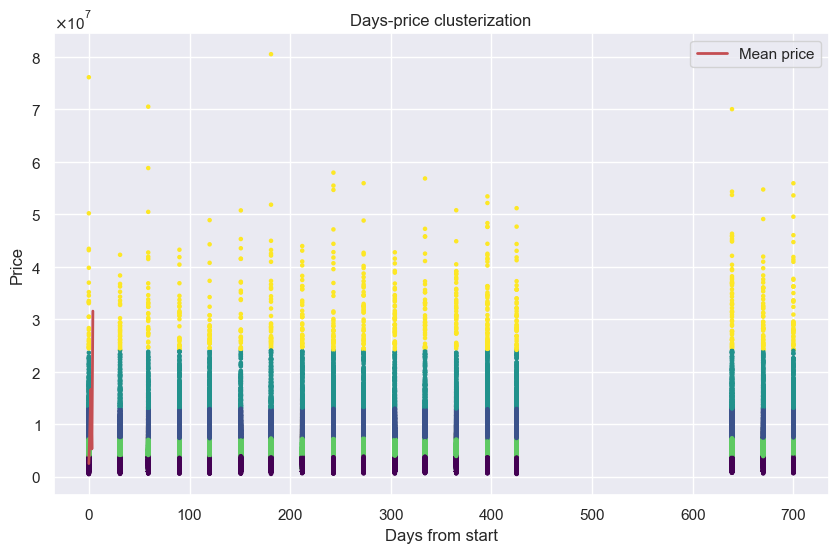

In [165]:
date_price['date'] = pd.to_datetime(date_price['date'])
date_price['days_from_start'] = (date_price['date'] - date_price['date'].min()).dt.days

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

date_price['date_cluster'] = kmeans.fit_predict(date_price[['days_from_start', 'price']])

average_prices_by_cluster = date_price.groupby('date_cluster')['price'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(date_price['days_from_start'], date_price['price'], c=date_price['date_cluster'], cmap='viridis',
            s = 5,
            marker='o')
plt.gca().yaxis.set_major_formatter(formatter)
plt.plot(average_prices_by_cluster.index, average_prices_by_cluster.values, 'r-', linewidth=2, label='Mean price')
plt.xlabel('Days from start')
plt.ylabel('Price')
plt.title('Days-price clusterization')
plt.legend()
plt.show()

### So, not so remarkable clusters to be honest. Let's create the days from start feature:

In [166]:
prices_dataset['date'] = pd.to_datetime(prices_dataset['date'])
prices_dataset['days_from_start'] = (prices_dataset['date'] - prices_dataset['date'].min()).dt.days
# prices_dataset = prices_dataset.drop(columns = ['date'])
prices_dataset.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,days_from_start
0,2011-04-01,0,1.0,5,61,3,0,25.0,1,0,...,0,0,0,0,0,0,0,0,4294000,90
1,2011-03-01,0,0.0,3,31,1,0,30.0,2,0,...,0,0,0,0,0,0,0,0,1572000,59
2,2011-12-01,0,0.0,6,63,3,0,15.0,2,0,...,0,0,0,0,0,0,0,0,5380000,334
3,2011-07-01,0,1.0,1,61,3,1,10.0,7,0,...,0,0,0,0,0,0,0,0,6106000,181
4,2011-12-01,0,1.0,1,34,1,0,20.0,4,1,...,0,0,0,0,0,0,0,0,3805000,334


In [167]:
prices_test_dataset['date'] = pd.to_datetime(prices_test_dataset['date'])
prices_test_dataset['days_from_start'] = (prices_test_dataset['date'] - prices_dataset['date'].min()).dt.days
prices_test_dataset = prices_test_dataset.drop(columns = ['date'])
prices_test_dataset.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,days_from_start
0,459,1.0,1,60,3,1,30.000000,4,0,0,...,0,0,0,0,0,0,0,0,0,425
1,344,1.0,10,52,2,1,22.081353,4,0,0,...,0,0,0,0,0,0,0,0,0,425
2,585,0.0,4,54,3,0,30.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,425
3,494,1.0,2,52,2,1,25.000000,3,0,1,...,0,0,0,0,0,0,0,0,0,425
4,622,1.0,9,60,3,1,15.000000,1,1,1,...,0,0,0,0,0,0,0,0,0,425


In [168]:
prices_dataset = prices_dataset.drop(columns = ['date'])

In [169]:
prices_dataset.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,days_from_start
0,0,1.0,5,61,3,0,25.0,1,0,1,...,0,0,0,0,0,0,0,0,4294000,90
1,0,0.0,3,31,1,0,30.0,2,0,0,...,0,0,0,0,0,0,0,0,1572000,59
2,0,0.0,6,63,3,0,15.0,2,0,1,...,0,0,0,0,0,0,0,0,5380000,334
3,0,1.0,1,61,3,1,10.0,7,0,1,...,0,0,0,0,0,0,0,0,6106000,181
4,0,1.0,1,34,1,0,20.0,4,1,0,...,0,0,0,0,0,0,0,0,3805000,334


### Transform the street_id:

### Again let's try to build the clusters:

In [170]:
street_price = prices_dataset[['street_id', 'price']]
mean_price = street_price.groupby('street_id')['price'].mean().reset_index(name = 'mean_price')
# mean_price.head()
# street_price.head()
street_price = street_price.merge(mean_price, on = 'street_id')
street_price.head()

,street_id,price,mean_price
0,0,4294000,3.629694e+06
1,0,1572000,3.629694e+06
2,0,5380000,3.629694e+06
3,0,6106000,3.629694e+06
4,0,3805000,3.629694e+06


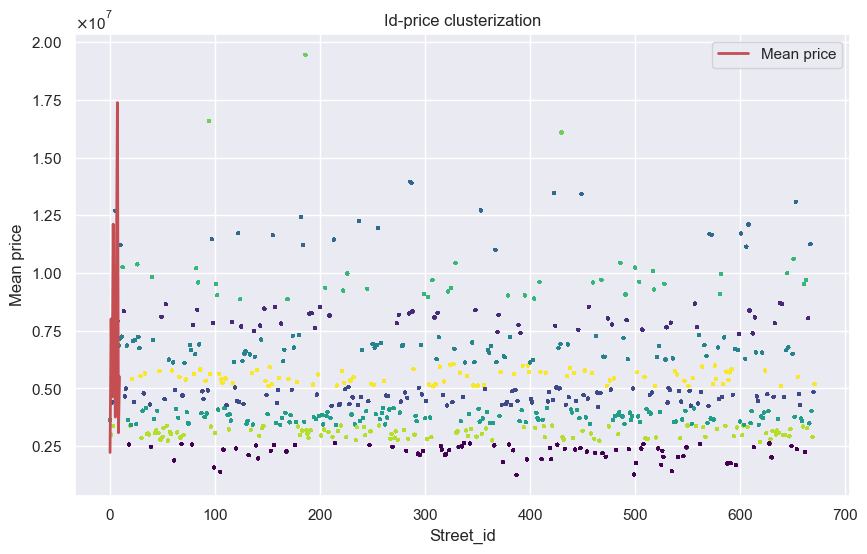

In [171]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

street_price['street_cluster'] = kmeans.fit_predict(street_price[['street_id', 'mean_price']])

average_prices_by_cluster = street_price.groupby('street_cluster')['price'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(street_price['street_id'], street_price['mean_price'], c=street_price['street_cluster'], cmap='viridis',
            s = 2,
            marker='o')
plt.gca().yaxis.set_major_formatter(formatter)
plt.plot(average_prices_by_cluster.index, average_prices_by_cluster.values, 'r-', linewidth=2, label='Mean price')
plt.xlabel('Street_id')
plt.ylabel('Mean price')
plt.title('Id-price clusterization')
# plt.xlim([0, 50])
plt.legend()
plt.show()

In [172]:
street_price[street_price['mean_price'] == street_price['mean_price'].max()].head()

,street_id,price,mean_price,street_cluster
27812,186,33553000,1.944087e+07,7
27813,186,14706000,1.944087e+07,7
27814,186,1000000,1.944087e+07,7
27815,186,24270000,1.944087e+07,7
27816,186,18149000,1.944087e+07,7


### Ok, let it be 10 clusters:

In [173]:
dict_groups = {}
for x, y in zip(street_price[['street_id', 'street_cluster']].drop_duplicates()['street_id'], street_price[['street_id', 'street_cluster']].drop_duplicates()['street_cluster']):
    dict_groups[x] = y


In [174]:
prices_dataset['street_id_cluster'] = street_price['street_cluster']

In [ ]:
prices_dataset = prices_dataset.drop(columns = ['street_id'])
prices_dataset.head()

In [146]:
one_hot_encoded_streets = pd.get_dummies(prices_dataset['street_id_cluster'], prefix = 'street_id_cluster')
prices_dataset = pd.concat([prices_dataset, one_hot_encoded_streets], axis = 1)

In [153]:
prices_dataset.iloc[:, 23:] = prices_dataset.iloc[:, 23:].astype(int)
prices_dataset.head()

,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,kw3,...,street_id_cluster_0,street_id_cluster_1,street_id_cluster_2,street_id_cluster_3,street_id_cluster_4,street_id_cluster_5,street_id_cluster_6,street_id_cluster_7,street_id_cluster_8,street_id_cluster_9
0,2.0,5,61,3,0,25.0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,3,31,1,0,30.0,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.0,6,63,3,0,15.0,2,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,1,61,3,1,10.0,7,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1.0,1,34,1,0,20.0,4,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [175]:
prices_dataset.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,days_from_start,street_id_cluster
0,0,1.0,5,61,3,0,25.0,1,0,1,...,0,0,0,0,0,0,0,4294000,90,5
1,0,0.0,3,31,1,0,30.0,2,0,0,...,0,0,0,0,0,0,0,1572000,59,5
2,0,0.0,6,63,3,0,15.0,2,0,1,...,0,0,0,0,0,0,0,5380000,334,5
3,0,1.0,1,61,3,1,10.0,7,0,1,...,0,0,0,0,0,0,0,6106000,181,5
4,0,1.0,1,34,1,0,20.0,4,1,0,...,0,0,0,0,0,0,0,3805000,334,5


In [181]:
dict_groups[344]

8

In [177]:
prices_test_dataset['street_id_group'] = prices_test_dataset['street_id'].map(dict_groups)

In [179]:
prices_test_dataset.head(10)

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,days_from_start,street_id_group
0,459,1.0,1,60,3,1,30.000000,4,0,0,...,0,0,0,0,0,0,0,0,425,9
1,344,1.0,10,52,2,1,22.081353,4,0,0,...,0,0,0,0,0,0,0,0,425,8
2,585,0.0,4,54,3,0,30.000000,0,0,0,...,0,0,0,0,0,0,0,0,425,4
3,494,1.0,2,52,2,1,25.000000,3,0,1,...,0,0,0,0,0,0,0,0,425,0
4,622,1.0,9,60,3,1,15.000000,1,1,1,...,0,0,0,0,0,0,0,0,425,5
5,664,1.0,12,60,3,1,20.000000,2,0,0,...,0,0,0,0,0,0,0,0,425,8
6,139,1.0,3,35,1,1,30.000000,1,0,1,...,0,0,0,0,0,0,0,0,425,0
7,387,0.0,1,58,3,0,20.000000,5,0,0,...,0,0,0,0,0,0,0,0,425,0
8,495,1.0,8,34,1,1,25.000000,1,0,1,...,0,0,0,0,0,0,0,0,425,5
9,334,1.0,12,35,1,0,22.081353,5,0,0,...,0,0,0,0,0,0,0,0,425,5


In [225]:
one_hot_encoded_streets_test = pd.get_dummies(prices_test_dataset['street_id_group'], prefix = 'street_id_group')
prices_test_dataset = pd.concat([prices_test_dataset, one_hot_encoded_streets_test], axis = 1)

In [226]:
prices_test_dataset = prices_test_dataset.drop(columns = ['street_id_group'])

In [228]:
prices_test_dataset.iloc[:, 25:] = prices_test_dataset.iloc[:, 25:].astype(int)

In [229]:
prices_test_dataset.head()

,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,...,street_id_group_0,street_id_group_1,street_id_group_2,street_id_group_3,street_id_group_4,street_id_group_5,street_id_group_6,street_id_group_7,street_id_group_8,street_id_group_9
0,2.718282,30.000000,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.718282,22.081353,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.000000,30.000000,-6.907755,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2.718282,25.000000,1.098946,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2.718282,15.000000,0.001000,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Or let's try OHE:

In [105]:
one_hot_encoded_street = pd.get_dummies(prices_dataset['street_id'], prefix = 'street_id')
prices_dataset = pd.concat([prices_dataset, one_hot_encoded_street], axis = 1)

### Then, floor:

In [184]:
floor_price = prices_dataset[['floor', 'price']]
floor_price.head()

,floor,price
0,5,4294000
1,3,1572000
2,6,5380000
3,1,6106000
4,1,3805000


In [185]:
mean_price = floor_price.groupby('floor')['price'].mean().reset_index(name = 'mean_price')
# mean_price.head()
# street_price.head()
floor_price = floor_price.merge(mean_price, on = 'floor')
floor_price.head()

,floor,price,mean_price
0,5,4294000,4.572421e+06
1,5,4472000,4.572421e+06
2,5,3600000,4.572421e+06
3,5,1000000,4.572421e+06
4,5,4166000,4.572421e+06


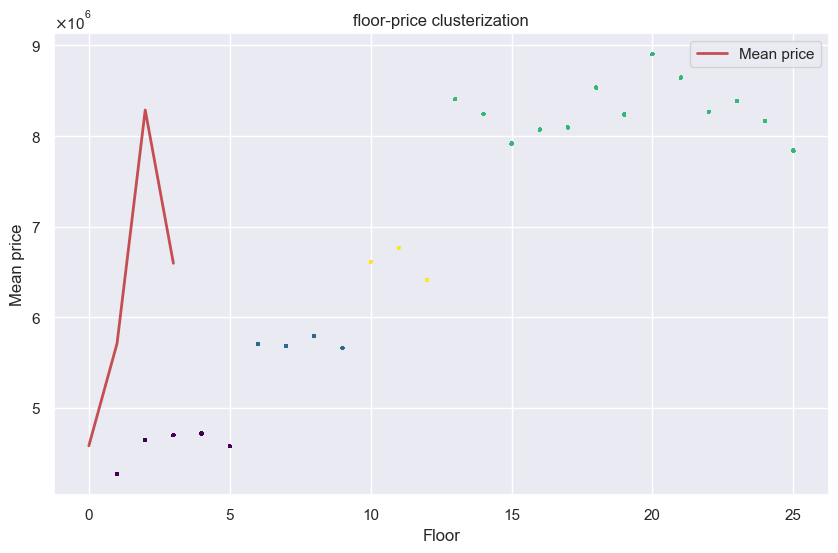

In [186]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

floor_price['floor_cluster'] = kmeans.fit_predict(floor_price[['floor', 'mean_price']])

average_prices_by_cluster = floor_price.groupby('floor_cluster')['price'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(floor_price['floor'], floor_price['mean_price'], c=floor_price['floor_cluster'], cmap='viridis',
            s = 2,
            marker='o')
plt.gca().yaxis.set_major_formatter(formatter)
plt.plot(average_prices_by_cluster.index, average_prices_by_cluster.values, 'r-', linewidth=2, label='Mean price')
plt.xlabel('Floor')
plt.ylabel('Mean price')
plt.title('floor-price clusterization')
# plt.xlim([0, 50])
plt.legend()
plt.show()

In [187]:
temp_dict = {}
for x, y in zip(floor_price[['floor', 'floor_cluster']].drop_duplicates()['floor'], 
                floor_price[['floor', 'floor_cluster']].drop_duplicates()['floor_cluster']):
    temp_dict[x] = y
   

### Let it be 4 clusters:

In [ ]:
prices_dataset = prices_dataset.drop(columns = ['floor_cluster'])

In [189]:
prices_dataset['floor_group'] = prices_dataset['floor'].map(temp_dict)

In [191]:
prices_test_dataset['floor_group'] = prices_test_dataset['floor'].map(temp_dict)

In [194]:
temp_dict[10]

3

In [192]:
prices_test_dataset.head()

,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,kw3,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,days_from_start,street_id_group,floor_group
0,1.0,1,60,3,1,30.000000,4,0,0,0,...,0,0,0,0,0,0,0,425,9,0
1,1.0,10,52,2,1,22.081353,4,0,0,0,...,0,0,0,0,0,0,0,425,8,3
2,0.0,4,54,3,0,30.000000,0,0,0,0,...,0,0,0,0,0,0,0,425,4,0
3,1.0,2,52,2,1,25.000000,3,0,1,0,...,0,0,0,0,0,0,0,425,0,0
4,1.0,9,60,3,1,15.000000,1,1,1,0,...,0,0,0,0,0,0,0,425,5,1


In [190]:
one_hot_encoded_floors = pd.get_dummies(prices_dataset['floor_group'], prefix = 'floor_group')
prices_dataset = pd.concat([prices_dataset, one_hot_encoded_floors], axis = 1)

In [195]:
one_hot_encoded_floors_test = pd.get_dummies(prices_test_dataset['floor_group'], prefix = 'floor_group')
prices_test_dataset = pd.concat([prices_test_dataset, one_hot_encoded_floors_test], axis = 1)

In [199]:
prices_test_dataset.iloc[:, 23:] = prices_test_dataset.iloc[:, 23:].astype(int)

In [201]:
prices_test_dataset = prices_test_dataset.drop(columns = ['floor_group'])

In [202]:
prices_test_dataset = prices_test_dataset.drop(columns = ['floor'])

In [113]:
prices_dataset.iloc[:, 34:] = prices_dataset.iloc[:, 34:].astype(int)

In [114]:
prices_dataset = prices_dataset.drop(columns = ['floor_group'])

In [115]:
prices_dataset = prices_dataset.drop(columns = ['floor'])

In [125]:
prices_dataset.iloc[:, 23:] = prices_dataset.iloc[:, 23:].astype(int)

In [126]:
prices_dataset.head()

,street_id,build_tech,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,kw3,...,street_id_666,street_id_667,street_id_668,street_id_669,street_id_670,street_id_671,floor_group_0,floor_group_1,floor_group_2,floor_group_3
0,0,1.0,61,3,0,25.0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0.0,31,1,0,30.0,2,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0.0,63,3,0,15.0,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1.0,61,3,1,10.0,7,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1.0,34,1,0,20.0,4,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [127]:
prices_dataset.iloc[:, 34:] = prices_dataset.iloc[:, 34:].astype(int)

In [230]:
prices_test_dataset.head()

,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,...,street_id_group_0,street_id_group_1,street_id_group_2,street_id_group_3,street_id_group_4,street_id_group_5,street_id_group_6,street_id_group_7,street_id_group_8,street_id_group_9
0,2.718282,30.000000,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.718282,22.081353,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.000000,30.000000,-6.907755,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2.718282,25.000000,1.098946,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2.718282,15.000000,0.001000,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### After build_tech:

In [128]:
one_hot_encoded_btech = pd.get_dummies(prices_dataset['build_tech'], prefix = 'build_tech')
prices_dataset = pd.concat([prices_dataset, one_hot_encoded_btech], axis = 1)

In [129]:
prices_dataset.iloc[:, 35:] = prices_dataset.iloc[:, 35:].astype(int)
prices_dataset = prices_dataset.drop(columns = 'build_tech')

In [204]:
one_hot_encoded_btech_test = pd.get_dummies(prices_test_dataset['build_tech'], prefix = 'build_tech')
prices_test_dataset = pd.concat([prices_test_dataset, one_hot_encoded_btech_test], axis = 1)

In [206]:
prices_test_dataset.iloc[:, 25:] = prices_test_dataset.iloc[:, 25:].astype(int)

In [208]:
prices_test_dataset = prices_test_dataset.drop(columns = ['build_tech'])

In [210]:
prices_test_dataset.head()

,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,...,kw13,days_from_start,street_id_group,floor_group_0,floor_group_1,floor_group_2,floor_group_3,build_tech_0.0,build_tech_1.0,build_tech_2.0
0,60,3,1,30.000000,4,0,0,0,0,0,...,0,425,9,1,0,0,0,0,1,0
1,52,2,1,22.081353,4,0,0,0,0,0,...,0,425,8,0,0,0,1,0,1,0
2,54,3,0,30.000000,0,0,0,0,0,0,...,0,425,4,1,0,0,0,1,0,0
3,52,2,1,25.000000,3,0,1,0,0,0,...,0,425,0,1,0,0,0,0,1,0
4,60,3,1,15.000000,1,1,1,0,0,0,...,0,425,5,0,1,0,0,0,1,0


### Area & Rooms:

In [211]:
prices_dataset['area_per_room'] = prices_dataset['area'] / prices_dataset['rooms']

In [131]:
prices_dataset = prices_dataset.drop(columns = ['area', 'rooms'])
prices_dataset.head()

,street_id,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,...,street_id_670,street_id_671,floor_group_0,floor_group_1,floor_group_2,floor_group_3,build_tech_0.0,build_tech_1.0,build_tech_2.0,area_per_room
0,0,0,25.0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,20.333333
1,0,0,30.0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,31.000000
2,0,0,15.0,2,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,21.000000
3,0,1,10.0,7,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,20.333333
4,0,0,20.0,4,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,34.000000


In [212]:
prices_test_dataset['area_per_room'] = prices_test_dataset['area'] / prices_test_dataset['rooms']

In [213]:
prices_test_dataset = prices_test_dataset.drop(columns = ['area', 'rooms'])
prices_test_dataset.head()

,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,...,days_from_start,street_id_group,floor_group_0,floor_group_1,floor_group_2,floor_group_3,build_tech_0.0,build_tech_1.0,build_tech_2.0,area_per_room
0,1,30.000000,4,0,0,0,0,0,0,0,...,425,9,1,0,0,0,0,1,0,20.0
1,1,22.081353,4,0,0,0,0,0,0,0,...,425,8,0,0,0,1,0,1,0,26.0
2,0,30.000000,0,0,0,0,0,0,0,0,...,425,4,1,0,0,0,1,0,0,18.0
3,1,25.000000,3,0,1,0,0,0,0,0,...,425,0,1,0,0,0,0,1,0,26.0
4,1,15.000000,1,1,1,0,0,0,0,0,...,425,5,0,1,0,0,0,1,0,20.0


### Balconies:

In [132]:
prices_dataset['balcon'] = np.exp(prices_dataset['balcon'])

In [133]:
prices_dataset.head()

,street_id,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,...,street_id_670,street_id_671,floor_group_0,floor_group_1,floor_group_2,floor_group_3,build_tech_0.0,build_tech_1.0,build_tech_2.0,area_per_room
0,0,1.000000,25.0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,20.333333
1,0,1.000000,30.0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,31.000000
2,0,1.000000,15.0,2,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,21.000000
3,0,2.718282,10.0,7,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,20.333333
4,0,1.000000,20.0,4,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,34.000000


In [214]:
prices_test_dataset['balcon'] = np.exp(prices_test_dataset['balcon'])

In [215]:
prices_test_dataset.head()

,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,...,days_from_start,street_id_group,floor_group_0,floor_group_1,floor_group_2,floor_group_3,build_tech_0.0,build_tech_1.0,build_tech_2.0,area_per_room
0,2.718282,30.000000,4,0,0,0,0,0,0,0,...,425,9,1,0,0,0,0,1,0,20.0
1,2.718282,22.081353,4,0,0,0,0,0,0,0,...,425,8,0,0,0,1,0,1,0,26.0
2,1.000000,30.000000,0,0,0,0,0,0,0,0,...,425,4,1,0,0,0,1,0,0,18.0
3,2.718282,25.000000,3,0,1,0,0,0,0,0,...,425,0,1,0,0,0,0,1,0,26.0
4,2.718282,15.000000,1,1,1,0,0,0,0,0,...,425,5,0,1,0,0,0,1,0,20.0


### And, finally, photos:

In [216]:
photos_price = prices_dataset[['n_photos', 'price']]
photos_price.head()

,n_photos,price
0,1,4294000
1,2,1572000
2,2,5380000
3,7,6106000
4,4,3805000


In [218]:
mean_price = photos_price.groupby('n_photos')['price'].mean().reset_index(name = 'mean_price')
# mean_price.head()
# street_price.head()
photos_price = photos_price.merge(mean_price, on = 'n_photos')
photos_price.head()

,n_photos,price,mean_price
0,1,4294000,4.628776e+06
1,1,1000000,4.628776e+06
2,1,1669000,4.628776e+06
3,1,3672000,4.628776e+06
4,1,3266000,4.628776e+06


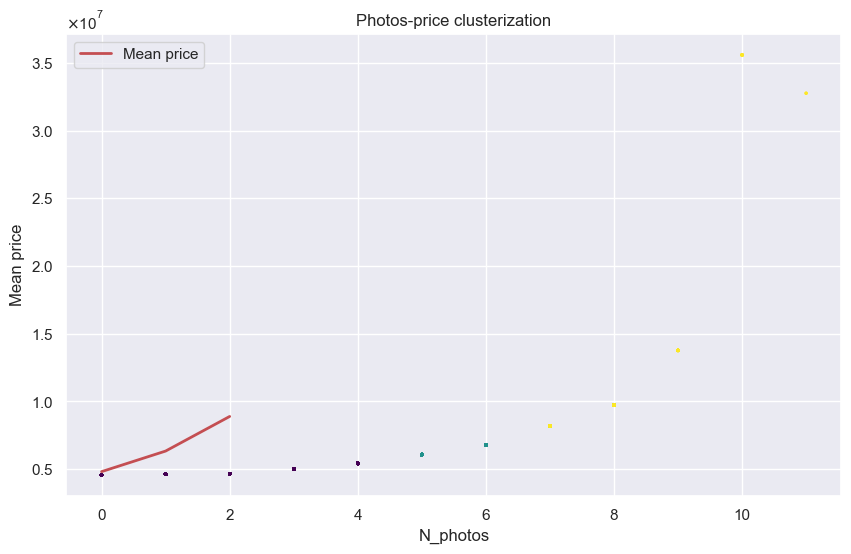

In [219]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

photos_price['photos_cluster'] = kmeans.fit_predict(photos_price[['n_photos', 'mean_price']])

average_prices_by_cluster = photos_price.groupby('photos_cluster')['price'].mean()

plt.figure(figsize=(10, 6))
plt.scatter(photos_price['n_photos'], photos_price['mean_price'], c=photos_price['photos_cluster'], cmap='viridis',
            s = 2,
            marker='o')
plt.gca().yaxis.set_major_formatter(formatter)
plt.plot(average_prices_by_cluster.index, average_prices_by_cluster.values, 'r-', linewidth=2, label='Mean price')
plt.xlabel('N_photos')
plt.ylabel('Mean price')
plt.title('Photos-price clusterization')
# plt.xlim([0, 50])
plt.legend()
plt.show()

### Ok, let's apply np.exp() cause it's numerical feature:

In [220]:
prices_dataset['n_photos'] = np.log(prices_dataset['n_photos'] + 0.001)

In [221]:
prices_dataset.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,...,kw13,price,days_from_start,street_id_cluster,floor_group,floor_group_0,floor_group_1,floor_group_2,floor_group_3,area_per_room
0,0,1.0,5,61,3,0,25.0,0.001000,0,1,...,0,4294000,90,5,0,True,False,False,False,20.333333
1,0,0.0,3,31,1,0,30.0,0.693647,0,0,...,0,1572000,59,5,0,True,False,False,False,31.000000
2,0,0.0,6,63,3,0,15.0,0.693647,0,1,...,0,5380000,334,5,1,False,True,False,False,21.000000
3,0,1.0,1,61,3,1,10.0,1.946053,0,1,...,0,6106000,181,5,0,True,False,False,False,20.333333
4,0,1.0,1,34,1,0,20.0,1.386544,1,0,...,0,3805000,334,5,0,True,False,False,False,34.000000


In [222]:
prices_test_dataset['n_photos'] = np.log(prices_test_dataset['n_photos'] + 0.001)

In [231]:
prices_test_dataset.head()

,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,...,street_id_group_0,street_id_group_1,street_id_group_2,street_id_group_3,street_id_group_4,street_id_group_5,street_id_group_6,street_id_group_7,street_id_group_8,street_id_group_9
0,2.718282,30.000000,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.718282,22.081353,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.000000,30.000000,-6.907755,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2.718282,25.000000,1.098946,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2.718282,15.000000,0.001000,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [233]:
prices_test_dataset.columns

Index(['balcon', 'metro_dist', 'n_photos', 'kw1', 'kw2', 'kw3', 'kw4', 'kw5',
       'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12', 'kw13',
       'days_from_start', 'floor_group_0', 'floor_group_1', 'floor_group_2',
       'floor_group_3', 'build_tech_0.0', 'build_tech_1.0', 'build_tech_2.0',
       'area_per_room', 'street_id_group_0', 'street_id_group_1',
       'street_id_group_2', 'street_id_group_3', 'street_id_group_4',
       'street_id_group_5', 'street_id_group_6', 'street_id_group_7',
       'street_id_group_8', 'street_id_group_9'],
      dtype='object')

### So, let's finally print all the features and save dataset:

In [ ]:
for column in prices_dataset.columns:
    print(column, type(prices_dataset[column][0]))

In [139]:
prices_dataset.to_csv('prices_dataset_transformed_and_preprocessed_ohe_streets.csv')

In [234]:
prices_test_dataset.to_csv('prices_test_dataset_transformed_and_preprocessed.csv')

### So, now we have the preprocessed data. 

In [114]:
prices_dataset = pd.read_csv('tools\\prices_dataset_transformed_and_preprocessed.csv')
prices_dataset = prices_dataset.drop(columns = ['Unnamed: 0'])

In [115]:
prices_dataset['rooms'] = rooms
prices_dataset['rooms'] = np.exp(prices_dataset['rooms'])

In [116]:
prices_test_dataset = pd.read_csv('tools\\prices_test_dataset_transformed_and_preprocessed.csv')
prices_test_dataset = prices_test_dataset.drop(columns = ['Unnamed: 0'])

In [117]:
prices_test_dataset['rooms'] = rooms_test
prices_test_dataset['rooms'] = np.exp(prices_test_dataset['rooms'])

In [234]:
def less_zero(x):
    return x if x > 0 else 0.001

prices_dataset['n_photos'] = prices_dataset[['n_photos']].applymap(less_zero) 

In [235]:
prices_test_dataset['n_photos'] = prices_test_dataset[['n_photos']].applymap(less_zero)

### Let's denote that all values are not NaN & there are no mistakes in dataset:

In [118]:
print(f"There are NaN values in dataset? - {prices_dataset.isna().values.any()}")

There are NaN values in dataset? - False


In [119]:
for column in prices_dataset.columns:
    if len(prices_dataset[prices_dataset[column].isna() == True]):
        print(column)

In [120]:
for column in prices_test_dataset.columns:
    if len(prices_test_dataset[prices_test_dataset[column].isna() == True]):
        print(column)

In [121]:
len(prices_test_dataset.columns)

36

In [122]:
prices_dataset = prices_dataset.drop(columns = ['street_id_cluster'])

In [123]:
len(prices_dataset.columns)

37

In [124]:
prices_test_dataset.columns = prices_test_dataset.columns.str.replace('group', 'cluster')
prices_dataset.columns = prices_dataset.columns.str.replace('group', 'cluster')

In [125]:
prices_test_dataset.head()

,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,...,street_id_cluster_1,street_id_cluster_2,street_id_cluster_3,street_id_cluster_4,street_id_cluster_5,street_id_cluster_6,street_id_cluster_7,street_id_cluster_8,street_id_cluster_9,rooms
0,2.718282,30.000000,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,20.085537
1,2.718282,22.081353,1.386544,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.389056
2,1.000000,30.000000,-6.907755,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,20.085537
3,2.718282,25.000000,1.098946,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.389056
4,2.718282,15.000000,0.001000,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,20.085537


### Here I want the same order of columns for both train & test:

In [126]:
prices_dataset = prices_dataset.reindex(sorted(prices_dataset.columns), axis=1)
prices_test_dataset = prices_test_dataset.reindex(sorted(prices_test_dataset.columns), axis=1)

In [127]:
prices_dataset.columns

Index(['area_per_room', 'balcon', 'build_tech_0.0', 'build_tech_1.0',
       'build_tech_2.0', 'days_from_start', 'floor_cluster_0',
       'floor_cluster_1', 'floor_cluster_2', 'floor_cluster_3', 'kw1', 'kw10',
       'kw11', 'kw12', 'kw13', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8',
       'kw9', 'metro_dist', 'n_photos', 'price', 'rooms',
       'street_id_cluster_0', 'street_id_cluster_1', 'street_id_cluster_2',
       'street_id_cluster_3', 'street_id_cluster_4', 'street_id_cluster_5',
       'street_id_cluster_6', 'street_id_cluster_7', 'street_id_cluster_8',
       'street_id_cluster_9'],
      dtype='object')

In [128]:
prices_test_dataset.columns

Index(['area_per_room', 'balcon', 'build_tech_0.0', 'build_tech_1.0',
       'build_tech_2.0', 'days_from_start', 'floor_cluster_0',
       'floor_cluster_1', 'floor_cluster_2', 'floor_cluster_3', 'kw1', 'kw10',
       'kw11', 'kw12', 'kw13', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw8',
       'kw9', 'metro_dist', 'n_photos', 'rooms', 'street_id_cluster_0',
       'street_id_cluster_1', 'street_id_cluster_2', 'street_id_cluster_3',
       'street_id_cluster_4', 'street_id_cluster_5', 'street_id_cluster_6',
       'street_id_cluster_7', 'street_id_cluster_8', 'street_id_cluster_9'],
      dtype='object')

### That's correct!

In [ ]:
for column in prices_dataset.columns:
    print(f"{column} number of unique values: ")
    print(len(prices_dataset[column].unique()))

In [ ]:
for column in prices_test_dataset.columns:
    print(f"{column} number of unique values: ")
    print(len(prices_test_dataset[column].unique()))

### Ok, let's start learning:

In [129]:
X_prices = prices_dataset.drop(columns = ['price'])
Y_prices = prices_dataset['price']

In [130]:
X_prices_test = prices_test_dataset

In [131]:
Y_prices.head()

0    4294000
1    1572000
2    5380000
3    6106000
4    3805000
Name: price, dtype: int64

In [132]:
X_train_prices, X_test_prices, Y_train_prices, Y_test_prices = train_test_split(X_prices, Y_prices,
                                                                                test_size = 0.2,
                                                                                random_state = 42)

In [133]:
X_train_prices.shape, Y_train_prices.shape

((80000, 36), (80000,))

In [134]:
X_test_prices.shape, Y_test_prices.shape

((20000, 36), (20000,))

In [261]:
scaler = StandardScaler()
scaler.fit(X_train_prices)
X_train_prices_scaled = scaler.transform(X_train_prices)

In [262]:
X_train_prices_scaled.shape

(80000, 35)

In [264]:
scaler = StandardScaler()
scaler.fit(X_test_prices)
X_test_prices_scaled = scaler.transform(X_test_prices)

In [265]:
X_test_prices_scaled.shape

(20000, 35)

### Here we go!

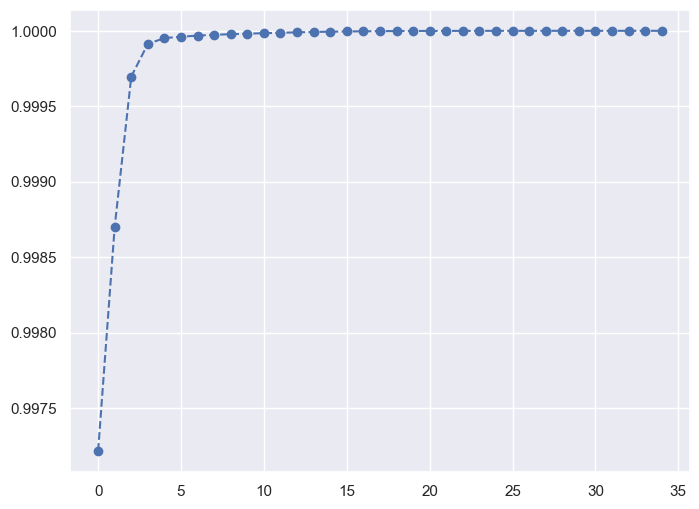

In [266]:
pca = PCA()
pca.fit(X_train_prices)

explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize = (8, 6))

plt.plot(np.cumsum(explained_variance_ratio), marker = 'o', linestyle = '--')

In [267]:
pca = PCA(n_components=20)
pca.fit(X_train_prices)

PCA(n_components=20)

### Tried to implement PCA but failed.

### Linear regression:

In [268]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_prices_scaled, Y_train_prices)

LinearRegression()

In [269]:
mean_absolute_error(y_true = Y_test_prices, y_pred = linear_regression.predict(X_test_prices_scaled))

4934169212824243.0

In [270]:
poly_features = PolynomialFeatures(degree=2)
poly_features.fit(X_train_prices)

lr_poly = LinearRegression()
lr_poly.fit(poly_features.transform(X_train_prices), Y_train_prices)

LinearRegression()

In [271]:
mean_absolute_error(y_true = Y_test_prices, y_pred = lr_poly.predict(poly_features.transform(X_test_prices)))

1607673.478299414

### Lasso:

In [272]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_prices, Y_train_prices)

c:\Users\Пользователь\PycharmProjects\pythonProject7\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.479e+16, tolerance: 1.416e+14
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [273]:
mean_absolute_error(y_true = Y_test_prices, y_pred = lasso.predict(X_test_prices))

1714582.2276614034

### Let's try different alphas:

In [ ]:
alphas = [0.001, 0.01, 0.1, 0.25, 0.4, 0.6, 0.8, 1.0]
mae_array_scaled = []
mae_array = []
for alpha in alphas:
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_prices_scaled, Y_train_prices)
    mae_array_scaled.append(mean_absolute_error(y_true = Y_test_prices, y_pred = lasso.predict(X_test_prices_scaled)))
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_prices, Y_train_prices)
    mae_array.append(mean_absolute_error(y_true = Y_test_prices, y_pred = lasso.predict(X_test_prices)))

Text(0, 0.5, 'MAE')

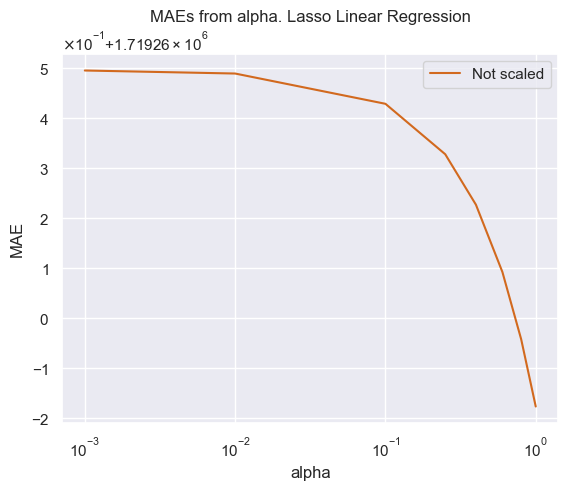

In [77]:
plt.gca().yaxis.set_major_formatter(formatter)
sns.lineplot(x = alphas, y = mae_array, label = 'Not scaled', color = 'chocolate')
# sns.lineplot(x = alphas, y = mae_array_scaled, label = 'Scaled', color = 'indigo')
plt.title('MAEs from alpha. Lasso Linear Regression')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

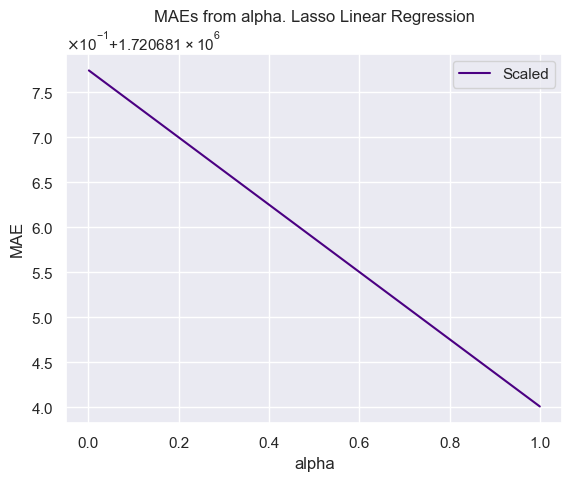

In [63]:
plt.gca().yaxis.set_major_formatter(formatter)
sns.lineplot(x = alphas, y = mae_array_scaled, label = 'Scaled', color = 'indigo')
plt.title('MAEs from alpha. Lasso Linear Regression')
plt.xlabel('alpha')
plt.ylabel('MAE')

### Ridge:

In [274]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_prices_scaled, Y_train_prices)

Ridge(alpha=1)

In [275]:
mean_absolute_error(y_true = Y_test_prices, y_pred = ridge.predict(X_test_prices_scaled))

1718149.0647364883

In [276]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_prices, Y_train_prices)

Ridge(alpha=1)

In [277]:
mean_absolute_error(y_true = Y_test_prices, y_pred = ridge.predict(X_test_prices))

1714568.2660163676

### Support Vector Regressor:

In [106]:
svr = LinearSVR(epsilon = 1)
svr.fit(X_train_prices, Y_train_prices)

LinearSVR(epsilon=1)

In [107]:
mean_absolute_error(y_true = Y_test_prices, y_pred = svr.predict(X_test_prices))

2652438.8316743374

### RandomForestRegressor:

In [279]:
rf_regressor = RandomForestRegressor(n_estimators=200, criterion='squared_error')
rf_regressor.fit(X_train_prices, Y_train_prices)

RandomForestRegressor(n_estimators=200)

In [280]:
rf_regressor_scaled = RandomForestRegressor(n_estimators=200, criterion='squared_error')
rf_regressor_scaled.fit(X_train_prices_scaled, Y_train_prices)

RandomForestRegressor(n_estimators=200)

In [281]:
print(f"MAE for not scaled regressor: {mean_absolute_error(y_true = Y_test_prices, y_pred = rf_regressor.predict(X_test_prices))}")
print(f"MAE for scaled regressor: {mean_absolute_error(y_true = Y_test_prices, y_pred = rf_regressor_scaled.predict(X_test_prices_scaled))}")

MAE for not scaled regressor: 1226462.2954504176
MAE for scaled regressor: 1258760.63793681


### Not bad.
### Than BaggingRegressor:

In [35]:
bagging_regressor = BaggingRegressor(n_estimators=100, 
                                     max_samples = 1.0,
                                     max_features = 1.0,
                                     bootstrap=True)
bagging_regressor.fit(X_train_prices, Y_train_prices)

BaggingRegressor(n_estimators=100)

In [41]:
mean_absolute_error(y_true = Y_test_prices, y_pred = bagging_regressor.predict(X_test_prices))

1234250.4724787902

### And voting regressor:

In [44]:
voting_regressor = VotingRegressor(estimators=[('ridge', Ridge(alpha = 1.0)), 
                                               ('dt', DecisionTreeRegressor()),
                                               ('rfr', RandomForestRegressor())])
voting_regressor.fit(X_train_prices, Y_train_prices)

VotingRegressor(estimators=[('ridge', Ridge()), ('dt', DecisionTreeRegressor()),
                            ('rfr', RandomForestRegressor())])

In [45]:
mean_absolute_error(y_true = Y_test_prices, y_pred = voting_regressor.predict(X_test_prices))

1331537.6887198533

### Ok, here we see that RandomForestRegressor is solid. Let's try to view the error distribution:

In [282]:
mae_rf_regressor_train = mean_absolute_error(y_true = Y_train_prices,
                                             y_pred = rf_regressor.predict(X_train_prices))
print(mae_rf_regressor_train)

477855.30406056


In [283]:
error = np.abs(Y_train_prices - rf_regressor.predict(X_train_prices))
error.shape

(80000,)

### Let's plot the histplot:

Text(0.5, 0, 'Absolute error')

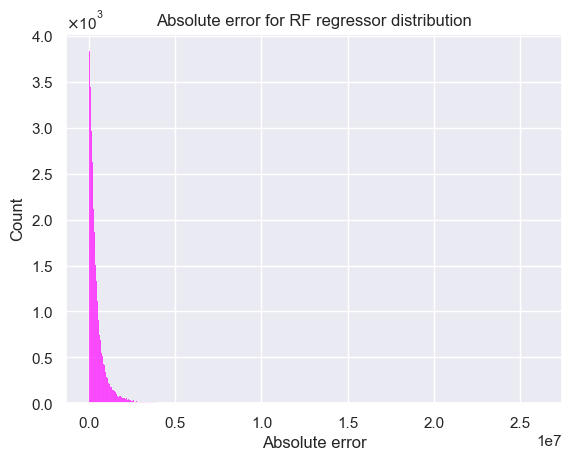

In [284]:
sns.histplot(x = error, color = 'fuchsia')
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Absolute error for RF regressor distribution')
plt.xlabel('Absolute error')

In [285]:
mask = (error < np.quantile(error, 0.95))
rf_regressor_update = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_depth = 50)
rf_regressor_update.fit(X_train_prices[mask], Y_train_prices[mask])

RandomForestRegressor(max_depth=50, n_estimators=200)

In [286]:
print(f"MAE for not scaled regressor & filtered: {mean_absolute_error(y_true = Y_test_prices, y_pred = rf_regressor_update.predict(X_test_prices))}")

MAE for not scaled regressor & filtered: 1203196.4830386369


### Let's make the final result for submission:

In [65]:
Y_predicted_test_data = rf_regressor_update.predict(X_prices_test)

In [66]:
sample_submission = pd.read_csv('tools\\sample_submission.csv')

In [67]:
sample_submission['price'] = Y_predicted_test_data
sample_submission.to_csv('submit_second.csv')

### So, here we try to implement it for whole dataset:

In [68]:
rf_regressor_update = RandomForestRegressor(n_estimators=400, criterion='squared_error', max_depth = 75)
rf_regressor_update.fit(X_prices, Y_prices)

RandomForestRegressor(max_depth=75, n_estimators=400)

Text(0.5, 0, 'Absolute error')

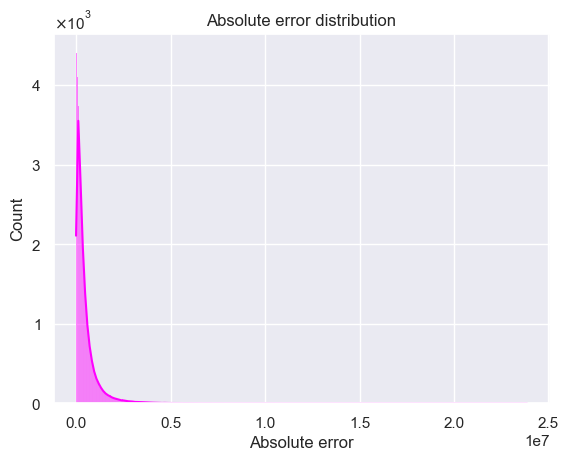

In [339]:
error = np.abs(Y_prices - rf_regressor_update.predict(X_prices))
sns.histplot(x = error, color = 'fuchsia', kde = True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Absolute error distribution')
plt.xlabel('Absolute error')

In [340]:
mask = (error < np.quantile(error, 0.95))
rf_regressor_update = RandomForestRegressor(n_estimators=400, criterion='squared_error', max_depth = 75)
rf_regressor_update.fit(X_prices[mask], Y_prices[mask])

RandomForestRegressor(max_depth=75, n_estimators=400)

In [69]:
Y_predicted_test_data = rf_regressor_update.predict(X_prices_test)

In [70]:
Y_predicted_test_data.shape

(100000,)

In [71]:
sample_submission = pd.read_csv('tools\\sample_submission.csv')

In [72]:
sample_submission['price'] = Y_predicted_test_data

In [73]:
sample_submission.to_csv('submit_third.csv')

### Let's try Gradient Boosting Regressor:

In [87]:
xgb_regressor_rooms_feature = XGBRegressor(n_estimators = 63,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_rooms_feature.fit(X_train_prices, Y_train_prices)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=63, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [88]:
print(f"MAE for NOT scaled data & rooms number included {mean_absolute_error(y_true = Y_test_prices, y_pred = xgb_regressor_rooms_feature.predict(X_test_prices))}")

MAE for NOT scaled data & rooms number included 990613.359178125


### So good! Let's filter that:


Text(0.5, 0, 'Absolute error')

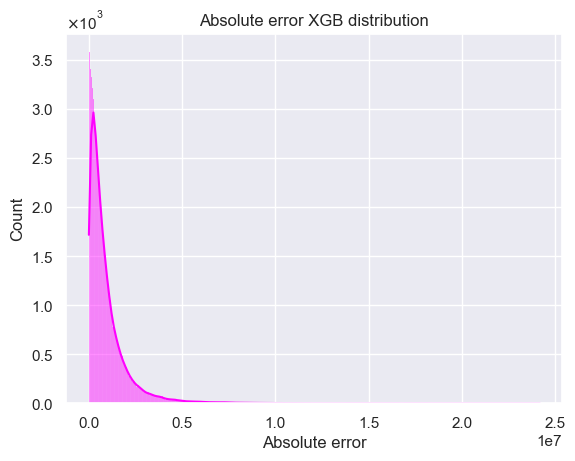

In [89]:
error = np.abs(Y_train_prices - xgb_regressor_rooms_feature.predict(X_train_prices))
sns.histplot(x = error, color = 'magenta', kde = True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Absolute error XGB distribution')
plt.xlabel('Absolute error')

In [110]:
mask = (error < np.quantile(error, 0.91))
xgb_regressor_update_rooms_feature = XGBRegressor(n_estimators = 63,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_update_rooms_feature.fit(X_train_prices[mask], Y_train_prices[mask])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=63, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
print(f"MAE for NOT scaled data & rooms number included and filtered {mean_absolute_error(y_true = Y_test_prices, y_pred = xgb_regressor_update_rooms_feature.predict(X_test_prices))}")

MAE for NOT scaled data & rooms number included and filtered 977847.926978125


### And whole dataset:

In [136]:
xgb_regressor_rooms_feature_whole_data = XGBRegressor(n_estimators = 63,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_rooms_feature_whole_data.fit(X_prices, Y_prices)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=63, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [138]:
error = np.abs(Y_prices - xgb_regressor_rooms_feature_whole_data.predict(X_prices))
mask = (error < np.quantile(error, 0.91))
xgb_regressor_update_rooms_feature_whole_data = XGBRegressor(n_estimators = 63,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_update_rooms_feature_whole_data.fit(X_prices[mask], Y_prices[mask])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=63, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### And create submit file: (The best one)

In [140]:
sample_submission = pd.read_csv('tools\\sample_submission.csv')
Y_predicted_test_data = xgb_regressor_update_rooms_feature_whole_data.predict(X_prices_test)
sample_submission['price'] = Y_predicted_test_data
sample_submission.to_csv('submit_5th.csv')

### And next is ***without*** rooms feature:

In [303]:
xgb_regressor = XGBRegressor(n_estimators = 170,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor.fit(X_train_prices, Y_train_prices)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [288]:
xgb_regressor_scaled = XGBRegressor(n_estimators = 170,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_scaled.fit(X_train_prices_scaled, Y_train_prices)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [289]:
print(f"MAE for scaled data {mean_absolute_error(y_true = Y_test_prices, y_pred = xgb_regressor_scaled.predict(X_test_prices_scaled))}")

MAE for scaled data 1980498.646125


In [304]:
print(f"MAE for NOT scaled data {mean_absolute_error(y_true = Y_test_prices, y_pred = xgb_regressor.predict(X_test_prices))}")

MAE for NOT scaled data 1116020.826315332


Text(0.5, 0, 'Absolute error')

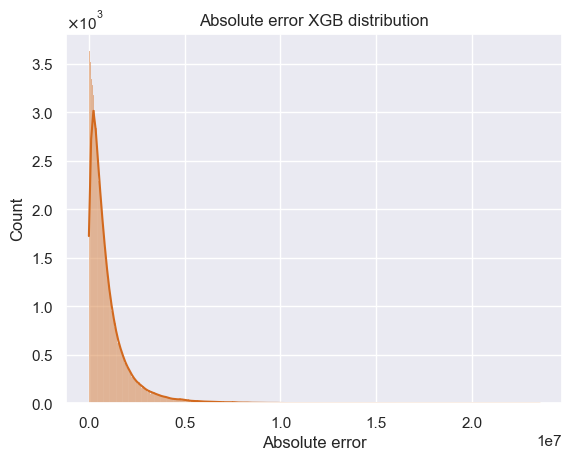

In [292]:
error = np.abs(Y_train_prices - xgb_regressor.predict(X_train_prices))
sns.histplot(x = error, color = 'chocolate', kde = True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Absolute error XGB distribution')
plt.xlabel('Absolute error')

### Filter that:

In [293]:
mask = (error < np.quantile(error, 0.928))
xgb_regressor_update = XGBRegressor(n_estimators = 170,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_update.fit(X_train_prices[mask], Y_train_prices[mask])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [294]:
mean_absolute_error(y_true = Y_test_prices, y_pred = xgb_regressor_update.predict(X_test_prices))

1096891.188653125

### Let's try whole dataset:

In [295]:
xgb_regressor_whole = XGBRegressor(n_estimators = 170,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_whole.fit(X_prices, Y_prices)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Absolute error')

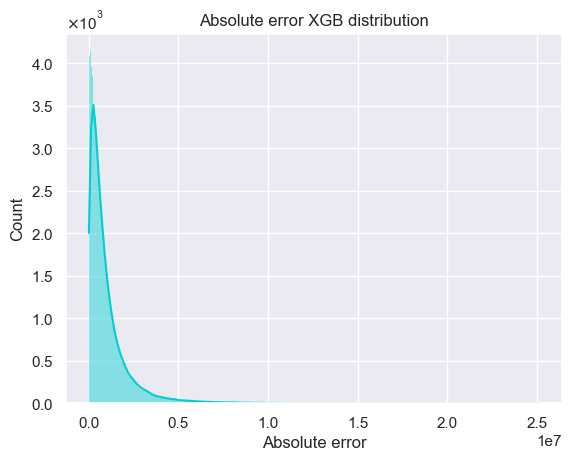

In [296]:
error = np.abs(Y_prices - xgb_regressor_whole.predict(X_prices))
sns.histplot(x = error, color = 'darkturquoise', kde = True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Absolute error XGB distribution')
plt.xlabel('Absolute error')

In [297]:
mask = (error < np.quantile(error, 0.93))
xgb_regressor_update_whole = XGBRegressor(n_estimators = 170,
                            # max_depth = 50,
                             objective = 'reg:squarederror')
xgb_regressor_update_whole.fit(X_prices[mask], Y_prices[mask])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Absolute error')

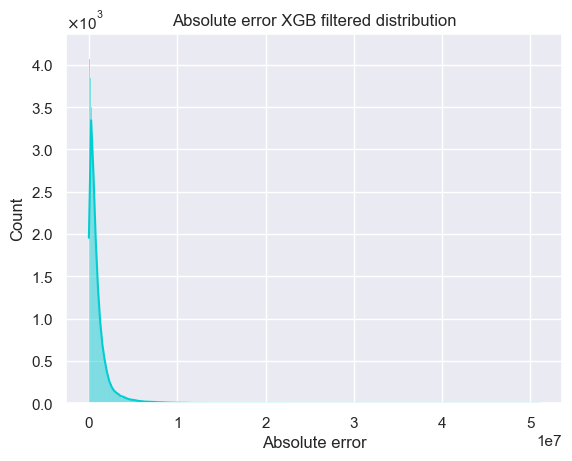

In [299]:
error = np.abs(Y_prices - xgb_regressor_update_whole.predict(X_prices))
sns.histplot(x = error, color = 'darkturquoise', kde = True)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Absolute error XGB filtered distribution')
plt.xlabel('Absolute error')

In [179]:
sample_submission = pd.read_csv('tools\\sample_submission.csv')
Y_predicted_test_data = xgb_regressor_update_whole.predict(X_prices_test)
sample_submission['price'] = Y_predicted_test_data

In [180]:
Y_predicted_test_data.shape

(100000,)

In [181]:
sample_submission.to_csv('submit_4th.csv')

### On the current moment we got that Gradient Boosting regressor resolution is solid. 
### It's time to try preceptron:

In [300]:
X_train_prices.shape[1]

35

In [32]:
perceptron_predict = Sequential()

perceptron_predict.add(Dense(64, 
                             activation='relu',
                             input_shape = (X_train_prices.shape[1], )))


perceptron_predict.add(Dense(64, 
                             activation='relu'))

perceptron_predict.add(Dense(64, 
                             activation='relu'))

perceptron_predict.add(Dense(64, activation = 'relu'))

perceptron_predict.add(Dense(1, activation = 'linear'))

perceptron_predict.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                2304      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_train_prices.shape, Y_train_prices.shape

((80000, 35), (80000,))

In [ ]:
perceptron_predict.compile(optimizer = tf.keras.optimizers.Adagrad(),
                           loss = 'mean_squared_error',
                           metrics = ['mean_absolute_error'])

perceptron_predict.fit(np.asarray(X_train_prices).astype(int), Y_train_prices, 
                       epochs = 500, 
                       batch_size = 8,
                       verbose = 2)

### Full learning history is [right here](tools/learning_review.txt)

In [44]:
mean_absolute_error(y_true = Y_test_prices, y_pred = perceptron_predict.predict(X_test_prices))

625/625 [==============================] - 1s 1ms/step


1432784.269946875

In [47]:
mean_absolute_error(y_true = Y_train_prices, y_pred = perceptron_predict.predict(X_train_prices))

2500/2500 [==============================] - 3s 1ms/step


1385355.9269839844

### So, the final knockout decision is for GB implementation. That's it!

###  ***The final <u>ermine</u> for you*** is [right here](tools/ermine.jpg)